In [1]:
import pandas as pd
import re
from fuzzywuzzy import process
from sentence_transformers import SentenceTransformer
import numpy as np

# Load data
df1 = pd.read_csv('surveydatashort.csv')
df2 = pd.read_csv('garageshortdata.csv')

# Preprocess text
# def preprocess(text):
#     text = text.lower().replace("|", " ").replace("-", " ")
#     text = re.sub(r'\b(rh|r)\b', 'right', text)
#     text = re.sub(r'\b(lh|l)\b', 'left', text)
#     return text

def preprocess(text):
    if isinstance(text, str):  # Check if the input is a string
        text = text.lower().replace("|", " ").replace("-", " ")
        text = re.sub(r'\b(rh|r)\b', 'right', text)
        text = re.sub(r'\b(lh|l)\b', 'left', text)
        return text
    return ""  # Return an empty string if text is not a string

df1['clean_key'] = df1['TXT_PARTS_NAME'].apply(preprocess)
df2['clean_value'] = df2['PARTDESCRIPTION'].apply(preprocess)

# Fuzzy Matching to get candidates
key_list = df1['clean_key'].tolist()
value_list = df2['clean_value'].tolist()

matches_dict = {}
for key in key_list:
    candidates = process.extract(key, value_list, limit=5)
    matches_dict[key] = [cand[0] for cand in candidates if cand[1] > 80]

# Semantic Similarity to refine matches
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
key_embeddings = model.encode(key_list)
value_embeddings = model.encode(value_list)

from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(key_embeddings, value_embeddings)

final_mapping = {}
for idx, key in enumerate(key_list):
    best_match_idx = np.argmax(similarity[idx])
    final_mapping[key] = value_list[best_match_idx]

# Save results
pd.DataFrame(final_mapping.items(), columns=['TXT_PARTS_NAME', 'PARTDESCRIPTION']).to_csv('shortmapping.csv')

C:\Users\Aman Jaiswal\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Aman Jaiswal\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aman Jaiswal\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to acti

In [2]:
import pandas as pd
import re
import json
from fuzzywuzzy import process
from sentence_transformers import SentenceTransformer
import numpy as np

# Load data
df1 = pd.read_csv('surveydatashort.csv')
df2 = pd.read_csv('garageshortdata.csv')

def preprocess(text):
    if isinstance(text, str):
        text = text.lower().replace("|", " ").replace("-", " ")
        text = re.sub(r'\b(rh|r)\b', 'right', text)
        text = re.sub(r'\b(lh|l)\b', 'left', text)
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return ' '.join(text.split()).strip()
    return ""

# Preprocess both datasets
df1['clean_key'] = df1['TXT_PARTS_NAME'].apply(preprocess)
df2['clean_value'] = df2['PARTDESCRIPTION'].apply(preprocess)

# Create mapping dictionaries
original_key_mapping = dict(zip(df1['clean_key'], df1['TXT_PARTS_NAME']))
original_value_mapping = dict(zip(df2['clean_value'], df2['PARTDESCRIPTION']))

# Get unique cleaned values
key_list = df1['clean_key'].unique().tolist()
value_list = df2['clean_value'].unique().tolist()

# Semantic similarity setup
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
key_embeddings = model.encode(key_list)
value_embeddings = model.encode(value_list)
similarity = cosine_similarity(key_embeddings, value_embeddings)

# Build the final mapping dictionary
result_dict = {}
SIMILARITY_THRESHOLD = 0.65  # Adjust this based on your validation

for key_idx, clean_key in enumerate(key_list):
    matches = []
    for value_idx, score in enumerate(similarity[key_idx]):
        if score > SIMILARITY_THRESHOLD:
            original_value = original_value_mapping[value_list[value_idx]]
            matches.append((original_value, score))

    # Sort matches by similarity score descending
    matches = sorted(matches, key=lambda x: x[1], reverse=True)

    # Get original key and store matches
    original_key = original_key_mapping[clean_key]
    result_dict[original_key] = [match[0] for match in matches]

# Add fuzzy matches for low-confidence items
FUZZY_THRESHOLD = 75
for original_key, clean_key in zip(df1['TXT_PARTS_NAME'], df1['clean_key']):
    if not result_dict.get(original_key):
        fuzzy_matches = process.extract(clean_key, value_list, limit=3)
        result_dict[original_key] = [
            original_value_mapping[match[0]]
            for match in fuzzy_matches
            if match[1] >= FUZZY_THRESHOLD
        ]

# Save to JSON
with open('parts_mapping.json', 'w') as f:
    json.dump(result_dict, f, indent=2)

print("JSON mapping created successfully!")

JSON mapping created successfully!


In [3]:
import pandas as pd
import re
import json
from fuzzywuzzy import process
from sentence_transformers import SentenceTransformer
import numpy as np

# Load data
df1 = pd.read_csv('../surveyor_data_cleanedd.csv')
df2 = pd.read_csv('../garagedata_cleaned_data.csv')

def preprocess(text):
    if isinstance(text, str):
        text = text.lower().replace("|", " ").replace("-", " ")
        text = re.sub(r'\b(rh|r)\b', 'right', text)
        text = re.sub(r'\b(lh|l)\b', 'left', text)
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return ' '.join(text.split()).strip()
    return ""

# Preprocess both datasets
df1['clean_key'] = df1['TXT_PARTS_NAME'].apply(preprocess)
df2['clean_value'] = df2['PARTDESCRIPTION'].apply(preprocess)

# Create mapping dictionaries
original_key_mapping = dict(zip(df1['clean_key'], df1['TXT_PARTS_NAME']))
original_value_mapping = dict(zip(df2['clean_value'], df2['PARTDESCRIPTION']))

# Get unique cleaned values
key_list = df1['clean_key'].unique().tolist()
value_list = df2['clean_value'].unique().tolist()

# Semantic similarity setup
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
key_embeddings = model.encode(key_list)
value_embeddings = model.encode(value_list)
similarity = cosine_similarity(key_embeddings, value_embeddings)

# Build the final mapping dictionary
result_dict = {}
SIMILARITY_THRESHOLD = 0.65  # Adjust this based on your validation

for key_idx, clean_key in enumerate(key_list):
    matches = []
    for value_idx, score in enumerate(similarity[key_idx]):
        if score > SIMILARITY_THRESHOLD:
            original_value = original_value_mapping[value_list[value_idx]]
            matches.append((original_value, score))

    # Sort matches by similarity score descending
    matches = sorted(matches, key=lambda x: x[1], reverse=True)

    # Get original key and store matches
    original_key = original_key_mapping[clean_key]
    result_dict[original_key] = [match[0] for match in matches]

# Add fuzzy matches for low-confidence items
FUZZY_THRESHOLD = 75
for original_key, clean_key in zip(df1['TXT_PARTS_NAME'], df1['clean_key']):
    if not result_dict.get(original_key):
        fuzzy_matches = process.extract(clean_key, value_list, limit=3)
        result_dict[original_key] = [
            original_value_mapping[match[0]]
            for match in fuzzy_matches
            if match[1] >= FUZZY_THRESHOLD
        ]

# Save to JSON
with open('Big_parts_mapping.json', 'w') as f:
    json.dump(result_dict, f, indent=2)

print("JSON mapping created successfully!")

JSON mapping created successfully!


In [11]:
import pandas as pd
import re
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load datasets
surveyor_df = pd.read_csv('Primary_Parts_Code.csv')  # Your new CSV with 30 categories
garage_df = pd.read_csv('garageshortdata.csv')

def preprocess(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\b(assembly|comp|assy|unit)\b', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Preprocess both datasets
surveyor_df['clean_name'] = surveyor_df['Surveyor Part Name'].apply(preprocess)
garage_df['clean_desc'] = garage_df['PARTDESCRIPTION'].apply(preprocess)

# Create encoder model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode categories
category_embeddings = model.encode(surveyor_df['clean_name'].tolist())
desc_embeddings = model.encode(garage_df['clean_desc'].tolist())

# Calculate similarity matrix
similarity_matrix = cosine_similarity(category_embeddings, desc_embeddings)

# Create mapping dictionary
category_mapping = {}
SIMILARITY_THRESHOLD = 0.65  # Adjust based on your needs

for idx, row in surveyor_df.iterrows():
    category_name = row['Surveyor Part Name']
    # part_code = row['Surveyor Part Code']
    key = f"{category_name}"

    # Get indices of garage descriptions with similarity above threshold
    matches = []
    for desc_idx, score in enumerate(similarity_matrix[idx]):
        if score > SIMILARITY_THRESHOLD:
            original_desc = garage_df.iloc[desc_idx]['PARTDESCRIPTION']
            matches.append((original_desc, score))

    # Sort matches by score and keep only descriptions
    matches = sorted(matches, key=lambda x: x[1], reverse=True)
    category_mapping[key] = [match[0] for match in matches]

# Add empty arrays for categories with no matches
for _, row in surveyor_df.iterrows():
    key = f"{row[' ']}"
    if key not in category_mapping:
        category_mapping[key] = []

# Save to JSON
with open('categorized_parts.json', 'w') as f:
    json.dump(category_mapping, f, indent=2)

print("JSON mapping created with 30 standard categories!")

KeyError: ' '

#Shortdata

In [15]:
import pandas as pd
import re
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def preprocess(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\b(assembly|comp|assy|unit)\b', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Load data
surveyor_df = pd.read_csv('Primary_Parts_Code.csv')
garage_df = pd.read_csv('garageshortdata.csv')

# Preprocess and clean data
surveyor_df['clean_name'] = surveyor_df['Surveyor Part Name'].apply(preprocess)
garage_df['clean_desc'] = garage_df['PARTDESCRIPTION'].apply(preprocess)

# Remove duplicate garage descriptions while keeping first occurrence
garage_df = garage_df.drop_duplicates(subset=['clean_desc'], keep='first')

# Encode texts
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
category_embeddings = model.encode(surveyor_df['clean_name'].tolist())
desc_embeddings = model.encode(garage_df['clean_desc'].tolist())

# Calculate similarity
similarity_matrix = cosine_similarity(category_embeddings, desc_embeddings)

# Create optimized mapping with duplicate removal
category_mapping = {}
SIMILARITY_THRESHOLD = 0.65

for idx, row in surveyor_df.iterrows():
    seen = set()
    unique_matches = []

    # Get sorted matches with scores
    matches = sorted(
        [(garage_df.iloc[desc_idx]['PARTDESCRIPTION'], score)
         for desc_idx, score in enumerate(similarity_matrix[idx])
         if score > SIMILARITY_THRESHOLD],
        key=lambda x: x[1],
        reverse=True
    )

    # Deduplicate while preserving order
    for desc, _ in matches:
        if desc not in seen:
            seen.add(desc)
            unique_matches.append(desc)

    # Create category key
    category_key = f"{row['Surveyor Part Name']}"
    category_mapping[category_key] = unique_matches

# Add empty arrays for unmatched categories
for _, row in surveyor_df.iterrows():
    category_key = f"{row['Surveyor Part Name']}"
    if category_key not in category_mapping:
        category_mapping[category_key] = []

# Save to JSON
with open('deduplicated_mapping.json', 'w') as f:
    json.dump(category_mapping, f, indent=2)

print("Clean JSON mapping with unique values created!")

Clean JSON mapping with unique values created!


Primary parts big data

In [19]:
import pandas as pd
import re
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def preprocess(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\b(assembly|comp|assy|unit)\b', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Load data
surveyor_df = pd.read_csv('Primary_Parts_Code.csv')
garage_df = pd.read_csv('../garagedata_cleaned_data.csv')

# Preprocess and clean data
surveyor_df['clean_name'] = surveyor_df['Surveyor Part Name'].apply(preprocess)
garage_df['clean_desc'] = garage_df['PARTDESCRIPTION'].apply(preprocess)

# Remove duplicate garage descriptions while keeping first occurrence
garage_df = garage_df.drop_duplicates(subset=['clean_desc'], keep='first')

# Encode texts
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
category_embeddings = model.encode(surveyor_df['clean_name'].tolist())
desc_embeddings = model.encode(garage_df['clean_desc'].tolist())

# Calculate similarity
similarity_matrix = cosine_similarity(category_embeddings, desc_embeddings)

# Create optimized mapping with duplicate removal
category_mapping = {}
SIMILARITY_THRESHOLD = 0.65

for idx, row in surveyor_df.iterrows():
    seen = set()
    unique_matches = []

    # Get sorted matches with scores
    matches = sorted(
        [(garage_df.iloc[desc_idx]['PARTDESCRIPTION'], score)
         for desc_idx, score in enumerate(similarity_matrix[idx])
         if score > SIMILARITY_THRESHOLD],
        key=lambda x: x[1],
        reverse=True
    )

    # Deduplicate while preserving order
    for desc, _ in matches:
        if desc not in seen:
            seen.add(desc)
            unique_matches.append(desc)

    # Create category key
    category_key = f"{row['Surveyor Part Name']}"
    category_mapping[category_key] = unique_matches

# Add empty arrays for unmatched categories
for _, row in surveyor_df.iterrows():
    category_key = f"{row['Surveyor Part Name']}"
    if category_key not in category_mapping:
        category_mapping[category_key] = []

# Save to JSON
with open('Bigdeduplicated_mapping.json', 'w') as f:
    json.dump(category_mapping, f, indent=2)

print("Clean JSON mapping with unique values created!")

Clean JSON mapping with unique values created!


data according to the modelnumber of garage data

In [101]:
import pandas as pd

input_csv = '../garagedata_cleaned_data.csv'
output_csv = 'filtered_garage_by_Vehicle_Number.csv'
target_codes = ['23103', '30135']  # Must be strings

# 1. Use COMMA delimiter and correct column names
cols_to_load = ['VEHICLE_MODEL_CODE', 'PARTDESCRIPTION','TOTAL_AMOUNT']

# 2. Optimized processing with correct separator
chunk_size = 50_000
first_chunk = True

for chunk in pd.read_csv(
    input_csv,
    sep=',',  # Changed to comma delimiter
    usecols=cols_to_load,
    dtype={'VEHICLE_MODEL_CODE': 'str'},
    chunksize=chunk_size
):
    filtered = chunk[chunk['VEHICLE_MODEL_CODE'].isin(target_codes)]

    filtered.to_csv(
        output_csv,
        mode='a' if not first_chunk else 'w',
        header=first_chunk,
        index=False
    )
    first_chunk = False

print("Filtering complete!")

Filtering complete!


In [40]:
# import json
# import pandas as pd
#
# # ------------------------------------------
# # 1. Load the JSON mapping file
# # ------------------------------------------
# json_file_path = "Bigdeduplicated_mapping.json"  # Replace with your JSON file path
#
# with open(json_file_path, 'r') as f:
#     json_data = json.load(f)
#
# # Create a flattened mapping dictionary
# # Format: {"specific_part_description": "category", ...}
# description_mapping = {}
# for category, part_descriptions in json_data.items():
#     for desc in part_descriptions:
#         description_mapping[desc] = category  # Map each term to its category
#
# # ------------------------------------------
# # 2. Load the CSV dataset
# # ------------------------------------------
# csv_file_path = "filtered_garage_by_Vehicle_Number.csv"  # Replace with your CSV file path
# df = pd.read_csv(csv_file_path)
#
# # ------------------------------------------
# # 3. Replace PARTDESCRIPTION using the JSON mapping
# # ------------------------------------------
# df["PARTDESCRIPTION"] = df["PARTDESCRIPTION"].str.lower().replace(description_mapping)
#
# # ------------------------------------------
# # 4. Save the updated CSV
# # ------------------------------------------
# output_csv_path = "GarageModel_Invoice_Data(Replaced).csv"
# df.to_csv(output_csv_path, index=False)
#
# print("CSV file updated successfully!")

CSV file updated successfully!


Standardiztize garage dataset according to the primary parts

In [44]:
import pandas as pd
import json

# Load mappings
with open('Bigdeduplicated_mapping.json') as f:
    mapping_data = json.load(f)

# Create reverse lookup
reverse_map = {}
for key, aliases in mapping_data.items():
    for alias in aliases:
        reverse_map[alias.strip().lower()] = key

# Process CSV with CORRECT DELIMITER
input_csv = 'filtered_garage_by_Vehicle_Number.csv'
output_csv = 'GarageModel_Invoice_Data(Replaced).csv'
chunk_size = 10000

# 1. Split columns properly using comma delimiter
first_chunk = True

for chunk in pd.read_csv(
    input_csv,
    sep=',',  # Changed to comma delimiter
    header=0,
    names=['VEHICLE_MODEL_CODE', 'PARTDESCRIPTION', 'TOTAL_AMOUNT'],  # Explicit column names
    chunksize=chunk_size
):
    # Normalize part descriptions
    chunk['clean_part'] = chunk['PARTDESCRIPTION'].str.strip().str.lower()

    # Map to new descriptions
    chunk['PARTDESCRIPTION'] = chunk['clean_part'].map(reverse_map).fillna(chunk['PARTDESCRIPTION'])

    # Save results
    chunk[['VEHICLE_MODEL_CODE', 'PARTDESCRIPTION', 'TOTAL_AMOUNT']] \
        .to_csv(
            output_csv,
            mode='a',
            header=first_chunk,
            index=False
        )
    first_chunk = False

print("Processing complete!")

Processing complete!


Now Working with Servey Data set

In [57]:
import pandas as pd

input_csv = '../surveyor_data_cleanedd.csv'
output_csv = 'filtered_garage_by_Vehicle_Number_of_Servey.csv'
target_codes = ['23103', '30135']  # Keep as strings

# 1. Add data validation and type conversion
chunk_size = 50_000
first_chunk = True
found_count = 0

for chunk in pd.read_csv(
    input_csv,
    sep=',',
    usecols=['VEHICLE_MODEL_CODE', 'TXT_PARTS_NAME', 'TOTAL_AMOUNT'],
    chunksize=chunk_size,
    dtype={
        'VEHICLE_MODEL_CODE': 'string',  # Force string type
        'TXT_PARTS_NAME': 'string',
        'TOTAL_AMOUNT': 'float64'
    }
):
    # Convert to string and clean vehicle codes
    chunk['VEHICLE_MODEL_CODE'] = chunk['VEHICLE_MODEL_CODE'].str.split('.').str[0]

    # Filter using cleaned codes
    filtered = chunk[chunk['VEHICLE_MODEL_CODE'].isin(target_codes)]

    # Debug: Show found matches
    if not filtered.empty:
        print(f"Found {len(filtered)} matches in chunk:")
        print(filtered[['VEHICLE_MODEL_CODE', 'TXT_PARTS_NAME']].head())
        found_count += len(filtered)

    # Write to CSV if any matches
    if not filtered.empty:
        filtered.to_csv(
            output_csv,
            mode='a',
            header=first_chunk,
            index=False
        )
        first_chunk = False

print(f"\nTotal matches found: {found_count}")
print("Filtering complete!" if found_count > 0 else "No matching records found!")

Found 831 matches in chunk:
    VEHICLE_MODEL_CODE           TXT_PARTS_NAME
70               23103  tail light housing left
71               23103                bracket 2
85               30135  horn assembly low pitch
86               30135        radiator assembly
149              23103     bumper rear assembly
Found 824 matches in chunk:
      VEHICLE_MODEL_CODE                      TXT_PARTS_NAME
50026              23103                       tank assembly
50027              23103            member comp front bumper
50173              23103  panel comp wheel house inner right
50248              23103                    garnish rdtr upr
50329              30135             fender panel front left
Found 801 matches in chunk:
       VEHICLE_MODEL_CODE              TXT_PARTS_NAME
100041              30135        runfront door glassl
100245              23103    member comp front bumper
100253              23103   stabilizer bar joint 2nos
100333              23103  bracket front bumpe

In [58]:
import pandas as pd
import json

# Load mappings
with open('Bigdeduplicated_mapping.json') as f:
    mapping_data = json.load(f)

# Create reverse lookup
reverse_map = {}
for key, aliases in mapping_data.items():
    for alias in aliases:
        reverse_map[alias.strip().lower()] = key

# Process CSV with CORRECT DELIMITER
input_csv = 'filtered_garage_by_Vehicle_Number_of_Servey.csv'
output_csv = 'ServeyModel_Invoice_Data(Replaced).csv'
chunk_size = 10000

# 1. Split columns properly using comma delimiter
first_chunk = True

for chunk in pd.read_csv(
    input_csv,
    sep=',',  # Changed to comma delimiter
    header=0,
    names=['VEHICLE_MODEL_CODE', 'TXT_PARTS_NAME', 'TOTAL_AMOUNT'],  # Explicit column names
    chunksize=chunk_size
):
    # Normalize part descriptions
    chunk['clean_part'] = chunk['TXT_PARTS_NAME'].str.strip().str.lower()

    # Map to new descriptions
    chunk['TXT_PARTS_NAME'] = chunk['clean_part'].map(reverse_map).fillna(chunk['TXT_PARTS_NAME'])

    # Save results
    chunk[['VEHICLE_MODEL_CODE', 'TXT_PARTS_NAME', 'TOTAL_AMOUNT']] \
        .to_csv(
            output_csv,
            mode='a',
            header=first_chunk,
            index=False
        )
    first_chunk = False

print("Processing complete!")

Processing complete!


Invoice for garage servey

In [69]:
import pandas as pd
from datetime import datetime

def generate_price_range_invoice():
    try:
        # Load and preprocess data
        df = pd.read_csv('GarageModel_Invoice_Data(Replaced).csv',
                        dtype={'VEHICLE_MODEL_CODE': str},
                        converters={'TOTAL_AMOUNT': float})

        # Clean data and handle duplicates
        df['PARTDESCRIPTION'] = df['PARTDESCRIPTION'].str.strip().str.title()

        # Group by vehicle model and part description to find price ranges
        grouped = df.groupby(['VEHICLE_MODEL_CODE', 'PARTDESCRIPTION']).agg(
            min_price=('TOTAL_AMOUNT', 'min'),
            max_price=('TOTAL_AMOUNT', 'max'),
            occurrence_count=('TOTAL_AMOUNT', 'count')
        ).reset_index()

        # Create price range strings
        grouped['price_range'] = grouped.apply(
            lambda x: f"${x['min_price']:.2f} - ${x['max_price']:.2f}"
            if x['min_price'] != x['max_price']
            else f"${x['min_price']:.2f}",
            axis=1
        )


        # Calculate vehicle-wise subtotals
        vehicle_totals = df.groupby('VEHICLE_MODEL_CODE').agg(
            total_spent=('TOTAL_AMOUNT', 'sum'),
            part_count=('PARTDESCRIPTION', 'count')
        ).reset_index()

        # Generate HTML invoice
        invoice_date = datetime.now().strftime('%Y-%m-%d')
        invoice_number = f"INV-{datetime.now().strftime('%Y%m%d-%H%M%S')}"

        html_content = f"""
        <html>
        <head>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 2cm; }}
                .header {{ text-align: center; border-bottom: 2px solid #000; }}
                table {{ width: 100%; border-collapse: collapse; margin-top: 20px; }}
                th, td {{ padding: 12px; text-align: left; border-bottom: 1px solid #ddd; }}
                .price-range {{ color: #2c3e50; font-weight: bold; }}
                .total-row {{ background-color: #f8f9fa; }}
            </style>
        </head>
        <body>
            <div class="header">
                <h1>Vehicle Parts Price Analysis By the Garage Agent</h1>
                <p>Report Number: {invoice_number}<br>
                Date: {invoice_date}</p>
            </div>
        """

        for vehicle in vehicle_totals['VEHICLE_MODEL_CODE'].unique():
            vehicle_data = grouped[grouped['VEHICLE_MODEL_CODE'] == vehicle]
            total_info = vehicle_totals[vehicle_totals['VEHICLE_MODEL_CODE'] == vehicle].iloc[0]

            html_content += f"""
            <div style="margin-top: 30px;">
                <h3>Vehicle Model: {vehicle}</h3>
                <table>
                    <tr>
                        <th>Part Description</th>
                        <th>Price Range</th>
                        <th></th>
                    </tr>"""

            for _, row in vehicle_data.iterrows():
                html_content += f"""
                    <tr>
                        <td>{row['PARTDESCRIPTION']}</td>
                        <td class="price-range">{row['price_range']}</td>
                        <td>{row['occurrence_count']}</td>
                    </tr>"""

            html_content += f"""
                    <tr class="total-row">
                        <td colspan="2"><strong>Total Parts Purchased</strong></td>
                        <td><strong>{total_info['part_count']}</strong></td>
                    </tr>
                    <tr class="total-row">
                        <td colspan="2"><strong>Total Amount Spent</strong></td>
                        <td><strong>${total_info['total_spent']:.2f}</strong></td>
                    </tr>
                </table>
            </div>
            """

        # Add grand totals
        grand_total = vehicle_totals['total_spent'].sum()
        html_content += f"""
            <div style="margin-top: 40px; border-top: 2px solid #000;">
                <h2>Grand Total Across All Vehicles: ${grand_total:.2f}</h2>
            </div>
        </body>
        </html>
        """

        # Save report
        with open('vehicle_parts_analysis_BY_Garage_Agent.html', 'w') as f:
            f.write(html_content)

        print("Report generated successfully as vehicle_parts_analysis BY Garage Agent.html")

    except Exception as e:
        print(f"Error generating report: {str(e)}")

if __name__ == "__main__":
    generate_price_range_invoice()

Report generated successfully as vehicle_parts_analysis BY Garage Agent.html


Servey Invoice

In [72]:
import pandas as pd
from datetime import datetime


def generate_price_range_invoiceByServey():
    try:
        # Load data and skip the repeated header row
        df = pd.read_csv('ServeyModel_Invoice_Data(Replaced).csv', dtype={'VEHICLE_MODEL_CODE': str}, skiprows=[1])

        # Ensure TOTAL_AMOUNT is numeric
        df['TOTAL_AMOUNT'] = pd.to_numeric(df['TOTAL_AMOUNT'], errors='coerce')  # Convert invalid values to NaN
        df = df.dropna(subset=['TOTAL_AMOUNT'])  # Drop rows with NaN in TOTAL_AMOUNT
        df['TOTAL_AMOUNT'] = df['TOTAL_AMOUNT'].astype(float)  # Ensure TOTAL_AMOUNT is a float

        # Clean data and handle duplicates
        df['TXT_PARTS_NAME'] = df['TXT_PARTS_NAME'].str.strip().str.title()

        # Group by vehicle model and part description to find price ranges
        grouped = df.groupby(['VEHICLE_MODEL_CODE', 'TXT_PARTS_NAME']).agg(
            min_price=('TOTAL_AMOUNT', 'min'),
            max_price=('TOTAL_AMOUNT', 'max'),
            occurrence_count=('TOTAL_AMOUNT', 'count')
        ).reset_index()

        # Create price range strings
        grouped['price_range'] = grouped.apply(
            lambda x: f"${x['min_price']:.2f} - ${x['max_price']:.2f}"
            if x['min_price'] != x['max_price']
            else f"${x['min_price']:.2f}",
            axis=1
        )

        # Calculate vehicle-wise subtotals
        vehicle_totals = df.groupby('VEHICLE_MODEL_CODE').agg(
            total_spent=('TOTAL_AMOUNT', 'sum'),
            part_count=('TXT_PARTS_NAME', 'count')
        ).reset_index()

        # Generate HTML invoice
        invoice_date = datetime.now().strftime('%Y-%m-%d')
        invoice_number = f"INV-{datetime.now().strftime('%Y%m%d-%H%M%S')}"

        html_content = f"""
        <html>
        <head>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 2cm; }}
                .header {{ text-align: center; border-bottom: 2px solid #000; }}
                table {{ width: 100%; border-collapse: collapse; margin-top: 20px; }}
                th, td {{ padding: 12px; text-align: left; border-bottom: 1px solid #ddd; }}
                .price-range {{ color: #2c3e50; font-weight: bold; }}
                .total-row {{ background-color: #f8f9fa; }}
            </style>
        </head>
        <body>
            <div class="header">
                <h1>Vehicle Parts Price Analysis By the Servey Agent</h1>
                <p>Report Number: {invoice_number}<br>
                Date: {invoice_date}</p>
            </div>
        """

        for vehicle in vehicle_totals['VEHICLE_MODEL_CODE'].unique():
            vehicle_data = grouped[grouped['VEHICLE_MODEL_CODE'] == vehicle]
            total_info = vehicle_totals[vehicle_totals['VEHICLE_MODEL_CODE'] == vehicle].iloc[0]

            html_content += f"""
            <div style="margin-top: 30px;">
                <h3>Vehicle Model: {vehicle}</h3>
                <table>
                    <tr>
                        <th>Part Description</th>
                        <th>Price Range</th>
                        <th>Occurrences</th>
                    </tr>"""

            for _, row in vehicle_data.iterrows():
                html_content += f"""
                    <tr>
                        <td>{row['TXT_PARTS_NAME']}</td>
                        <td class="price-range">{row['price_range']}</td>
                        <td>{row['occurrence_count']}</td>
                    </tr>"""

            html_content += f"""
                    <tr class="total-row">
                        <td colspan="2"><strong>Total Parts Purchased</strong></td>
                        <td><strong>{total_info['part_count']}</strong></td>
                    </tr>
                    <tr class="total-row">
                        <td colspan="2"><strong>Total Amount Spent</strong></td>
                        <td><strong>${total_info['total_spent']:.2f}</strong></td>
                    </tr>
                </table>
            </div>
            """

        # Add grand totals
        grand_total = vehicle_totals['total_spent'].sum()
        html_content += f"""
            <div style="margin-top: 40px; border-top: 2px solid #000;">
                <h2>Grand Total Across All Vehicles: ${grand_total:.2f}</h2>
            </div>
        </body>
        </html>
        """

        # Save report
        with open('vehicle_parts_analysis_BY_Servey_Agent.html', 'w') as f:
            f.write(html_content)

        print("Report generated successfully as vehicle_parts_analysis_BY_Servey_Agent.html")

    except Exception as e:
        print(f"Error generating report: {str(e)}")


if __name__ == "__main__":
    generate_price_range_invoiceByServey()


Report generated successfully as vehicle_parts_analysis_BY_Servey_Agent.html


Comparision between two garage and servey invoice

In [111]:
import pandas as pd
import numpy as np
from datetime import datetime


def compare_invoices(file1_path, file2_path):
    try:
        # Load datasets
        df1 = pd.read_csv(
            file1_path,
            dtype={'VEHICLE_MODEL_CODE': str},
            usecols=['VEHICLE_MODEL_CODE', 'PARTDESCRIPTION', 'TOTAL_AMOUNT']
        ).rename(columns={'PARTDESCRIPTION': 'PART_NAME'})

        df2 = pd.read_csv(
            file2_path,
            dtype={'VEHICLE_MODEL_CODE': str},
            usecols=['VEHICLE_MODEL_CODE', 'TXT_PARTS_NAME', 'TOTAL_AMOUNT']
        ).rename(columns={'TXT_PARTS_NAME': 'PART_NAME'})

        # Data cleaning function
        def clean_data(df):
            # Clean vehicle codes
            df['VEHICLE_MODEL_CODE'] = (
                df['VEHICLE_MODEL_CODE']
                .astype(str)
                .str.replace(r'\D', '', regex=True)
                .str.strip()
            )

            # Clean part names
            df['PART_NAME'] = (
                df['PART_NAME']
                .astype(str)
                .str.strip()
                .str.lower()
                .replace('nan', np.nan)
            )

            # Clean amounts
            df['TOTAL_AMOUNT'] = (
                df['TOTAL_AMOUNT']
                .astype(str)
                .str.replace(',', '')
                .str.replace(r'[^\d.]', '', regex=True)
                .replace(r'^\.$', np.nan, regex=True)
                .replace('', np.nan)
                .astype(float)
            )

            return df.dropna(subset=['PART_NAME', 'TOTAL_AMOUNT'])

        # Clean and aggregate data
        df1_clean = clean_data(df1)
        df2_clean = clean_data(df2)

        # Aggregate data with occurrence count
        def aggregate_data(df):
            aggregated = df.groupby(['VEHICLE_MODEL_CODE', 'PART_NAME']).agg(
                min_price=('TOTAL_AMOUNT', 'min'),
                max_price=('TOTAL_AMOUNT', 'max'),
                occurrences=('TOTAL_AMOUNT', 'count')
            ).reset_index()

            # Convert occurrences to integer type
            aggregated['occurrences'] = aggregated['occurrences'].astype(int)
            return aggregated

        # Aggregate and rename columns to avoid full prefixes for common fields (VEHICLE_MODEL_CODE, PART_NAME)
        agg1 = aggregate_data(df1_clean).rename(columns={
            'min_price': 'Garage_min_price',
            'max_price': 'Garage_max_price',
            'occurrences': 'Garage_occurrences'
        })

        agg2 = aggregate_data(df2_clean).rename(columns={
            'min_price': 'Servey_min_price',
            'max_price': 'Servey_max_price',
            'occurrences': 'Servey_occurrences'
        })

        # Merge aggregated data
        comparison = pd.merge(
            agg1,
            agg2,
            on=['VEHICLE_MODEL_CODE', 'PART_NAME'],
            how='outer',
            indicator=True
        )

        # Generate report
        generate_html_report(comparison)
        print("Report generated successfully: invoice_comparison.html")

    except Exception as e:
        error_html = f"""
        <html><body>
            <h1>Error</h1><p>{str(e)}</p>
        </body></html>
        """
        with open('invoice_comparison.html', 'w', encoding='utf-8') as f:
            f.write(error_html)
        print(f"Error: {str(e)}")


def generate_html_report(comparison):
    # Create content sections
    matched_content = create_matched_table(comparison)
    garage_unique = create_unique_table(comparison, 'left')
    servey_unique = create_unique_table(comparison, 'right')

    html_content = f"""
    <html>
    <head>
        <meta charset="UTF-8">
        <title>Invoice Comparison</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 2em; }}
            table {{ border-collapse: collapse; width: 100%; }}
            th, td {{ padding: 8px; text-align: left; border-bottom: 1px solid #ddd; }}
            .match {{ background-color: #e8f5e9; }}
            .garage-only {{ background-color: #fff3e0; }}
            .servey-only {{ background-color: #fbe9e7; }}
        </style>
    </head>
    <body>
        <h1>Invoice Comparison Report</h1>
        <p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>

        <h2>Matching Parts in Both Files</h2>
        {matched_content if matched_content else "<p>No matching parts found</p>"}

        <h2>Unique to Garage Data</h2>
        {garage_unique if garage_unique else "<p>No unique parts in Garage data</p>"}

        <h2>Unique to Servey Data</h2>
        {servey_unique if servey_unique else "<p>No unique parts in Servey data</p>"}
    </body>
    </html>
    """

    with open('invoice_comparison.html', 'w', encoding='utf-8') as f:
        f.write(html_content)


def create_matched_table(comparison):
    matched = comparison[comparison['_merge'] == 'both']
    if matched.empty:
        return ""

    return matched[[
        'VEHICLE_MODEL_CODE', 'PART_NAME',
        'Garage_min_price', 'Garage_max_price', 'Garage_occurrences',
        'Servey_min_price', 'Servey_max_price', 'Servey_occurrences'
    ]].to_html(index=False, classes='match', border=0)


def create_unique_table(comparison, side):
    prefix = 'Garage' if side == 'left' else 'Servey'
    unique = comparison[comparison['_merge'] == f'{side}_only']
    if unique.empty:
        return ""

    return unique[[
        'VEHICLE_MODEL_CODE', 'PART_NAME',
        f'{prefix}_min_price', f'{prefix}_max_price', f'{prefix}_occurrences'
    ]].to_html(index=False, classes=f'{prefix}-only', border=0)


# Execute comparison
compare_invoices('GarageModel_Invoice_Data(Replaced).csv', 'ServeyModel_Invoice_Data(Replaced).csv')


Report generated successfully: invoice_comparison.html


In [113]:
import pandas as pd
import json

# Load data
df = pd.read_csv("../garagedata_cleaned_data.csv")

# Load part mapping JSON
with open("Bigdeduplicated_mapping.json") as f:
    part_mapping = json.load(f)

# Create reverse mapping and primary part set
reverse_map = {}
primary_part_set = set()

for primary_part, secondary_list in part_mapping.items():
    normalized_primary = primary_part.lower().strip()
    primary_part_set.add(normalized_primary)

    for secondary in secondary_list:
        normalized_secondary = secondary.lower().strip()
        reverse_map[normalized_secondary] = normalized_primary

# Process parts data
def categorize_part(part_description):
    normalized_part = part_description.lower().strip()

    if normalized_part in reverse_map:
        return reverse_map[normalized_part]
    elif normalized_part in primary_part_set:
        return normalized_part
    else:
        return None

df['primary_part'] = df['PARTDESCRIPTION'].apply(categorize_part)
df['secondary_part'] = df.apply(
    lambda x: x['PARTDESCRIPTION'] if pd.isnull(x['primary_part']) else None,
    axis=1
)

Most Commonly Damaged Primary Parts:
                         Primary Part  Count  Percentage
0               bumper front assembly  57853       20.07
1                bumper rear assembly  55477       19.24
2               grille radiator upper  44949       15.59
3                     head light left  23575        8.18
4                    head light right  21675        7.52
5              windshield glass front  18359        6.37
6        glass rear door window right  10605        3.68
7                    door front right   8555        2.97
8               fog light front right   8408        2.92
9  fender|wing|side panel front right   7227        2.51


C:\Users\Aman Jaiswal\AppData\Local\Temp\ipykernel_11004\1810664673.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


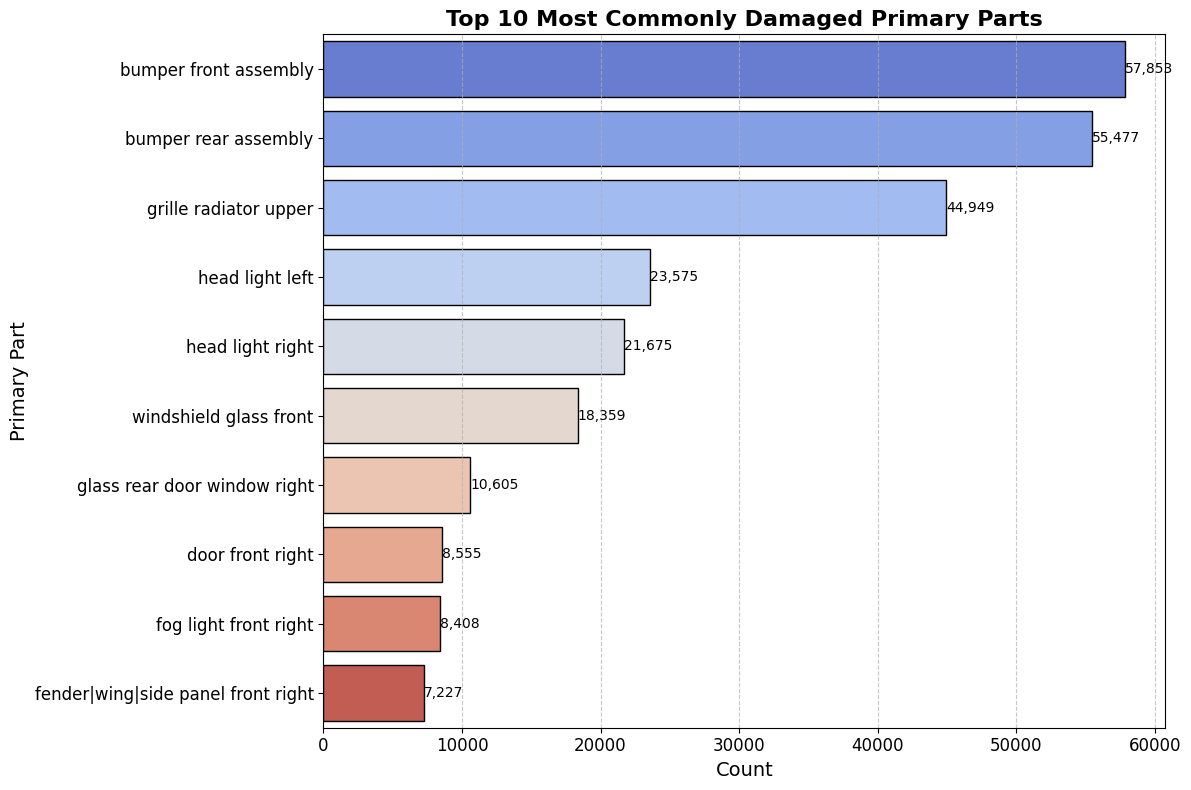

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate primary part analysis
primary_analysis = df['primary_part'].value_counts().reset_index()
primary_analysis.columns = ['Primary Part', 'Count']
total = primary_analysis['Count'].sum()
primary_analysis['Percentage'] = (primary_analysis['Count'] / total * 100).round(2)

# Display most commonly damaged primary parts
print("Most Commonly Damaged Primary Parts:")
print(primary_analysis.head(10))

# Enhanced visualization: Horizontal bar plot for better readability
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Count',
    y='Primary Part',
    data=primary_analysis.head(10),  # Display top 10
    palette='coolwarm',
    edgecolor='black'
)

# Add labels and title
plt.title("Top 10 Most Commonly Damaged Primary Parts", fontsize=16, fontweight='bold')
plt.xlabel("Count", fontsize=14)
plt.ylabel("Primary Part", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value annotations on the bars
for index, value in enumerate(primary_analysis['Count'][:10]):
    plt.text(value + 1, index, f"{value:,}", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.show()

C:\Users\Aman Jaiswal\AppData\Local\Temp\ipykernel_11004\3577289864.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


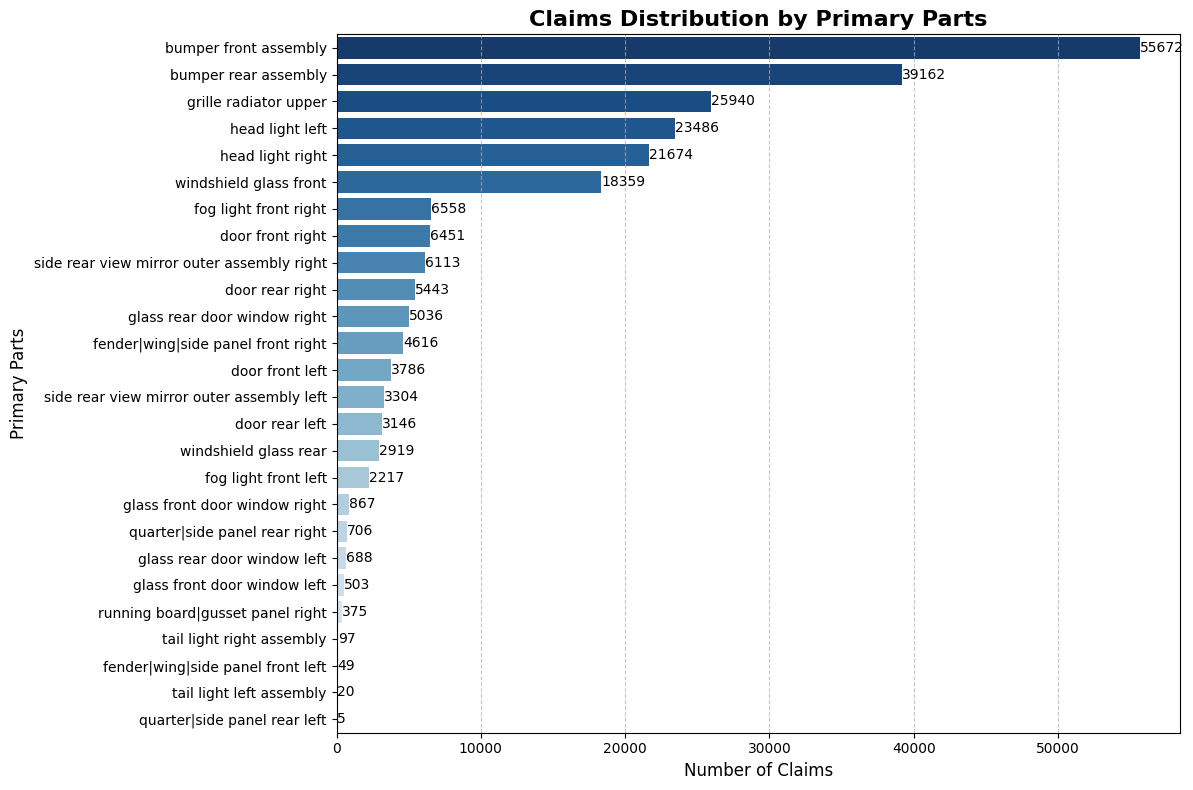


Claims Distribution by Primary Parts:
                                  Primary Part  Claim Count
0                        bumper front assembly        55672
1                         bumper rear assembly        39162
14                       grille radiator upper        25940
15                             head light left        23486
16                            head light right        21674
24                      windshield glass front        18359
9                        fog light front right         6558
3                             door front right         6451
21  side rear view mirror outer assembly right         6113
5                              door rear right         5443
13                glass rear door window right         5036
7           fender|wing|side panel front right         4616
2                              door front left         3786
20   side rear view mirror outer assembly left         3304
4                               door rear left         3146
2

In [141]:
# Improved visualization for claims distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
claims_distribution = df.groupby('primary_part')['CLAIMNO'].nunique().reset_index()
claims_distribution.columns = ['Primary Part', 'Claim Count']
claims_distribution = claims_distribution.sort_values('Claim Count', ascending=False)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Claim Count',
    y='Primary Part',
    data=claims_distribution,
    palette='Blues_r'
)

# Add labels and title
plt.title("Claims Distribution by Primary Parts", fontsize=16, fontweight='bold')
plt.xlabel("Number of Claims", fontsize=12)
plt.ylabel("Primary Parts", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value annotations on bars
for index, value in enumerate(claims_distribution['Claim Count']):
    plt.text(value + 1, index, str(value), va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Print the data (optional)
print("\nClaims Distribution by Primary Parts:")
print(claims_distribution)

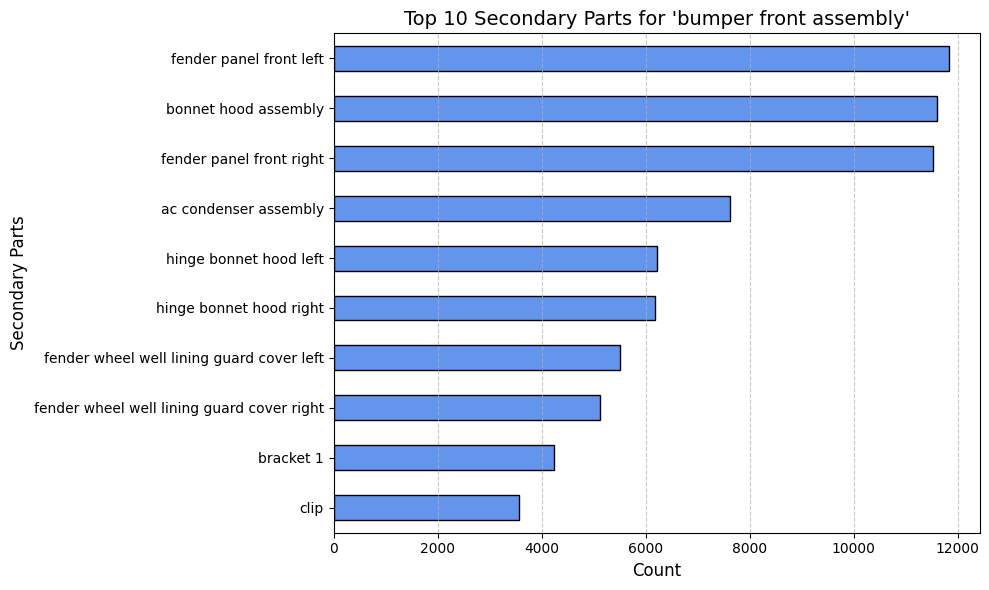

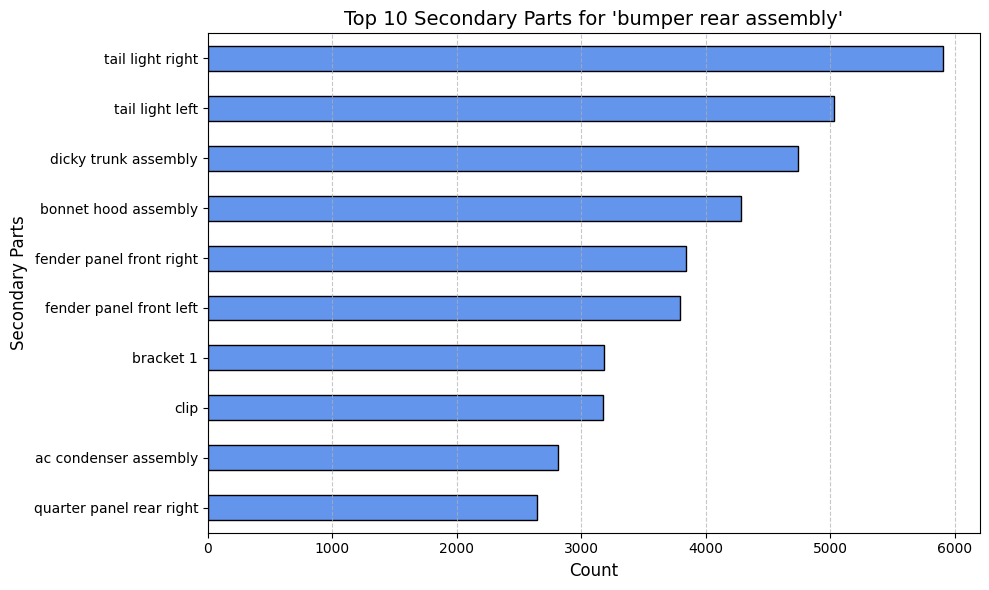

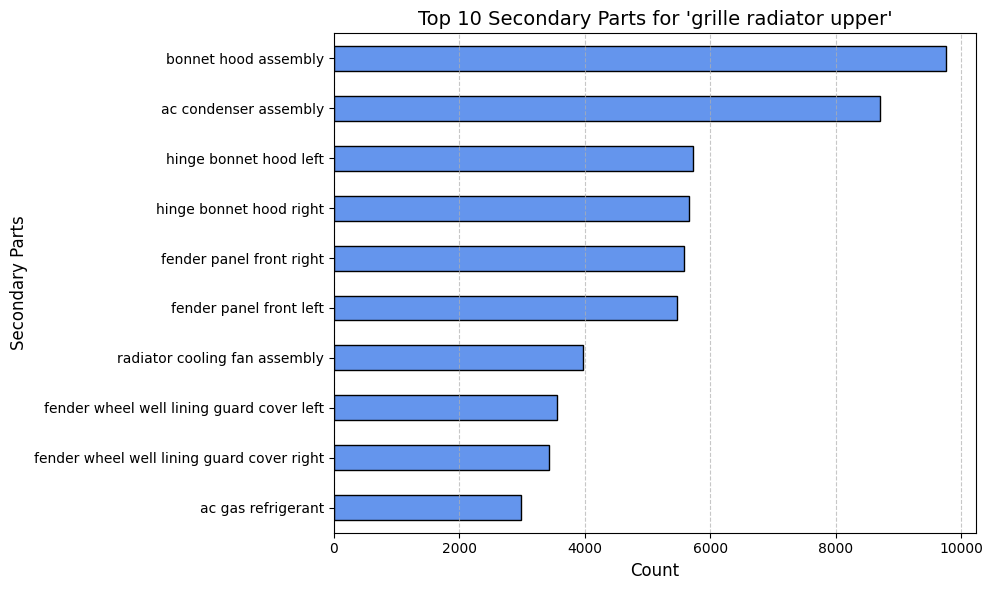

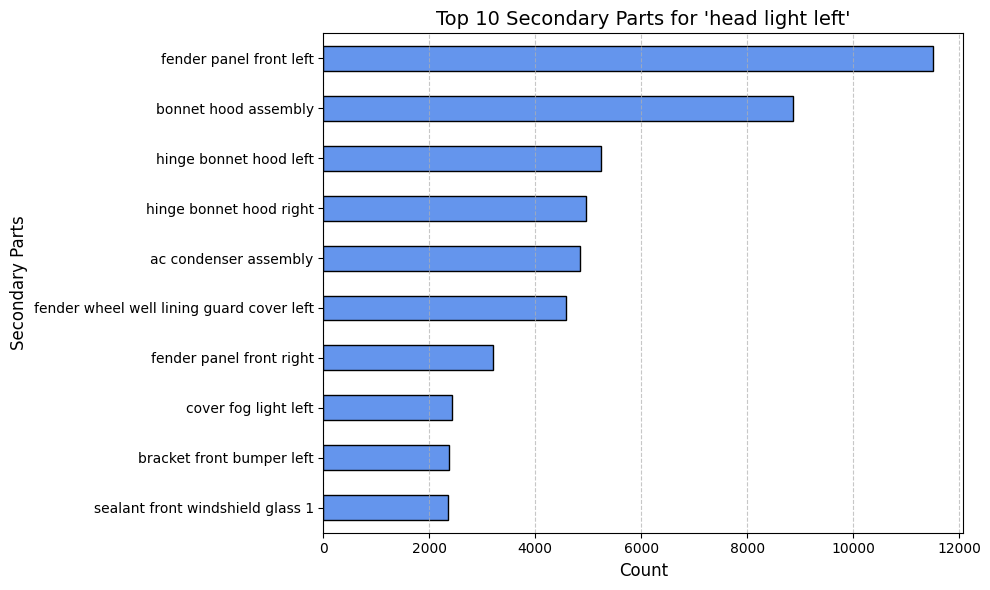

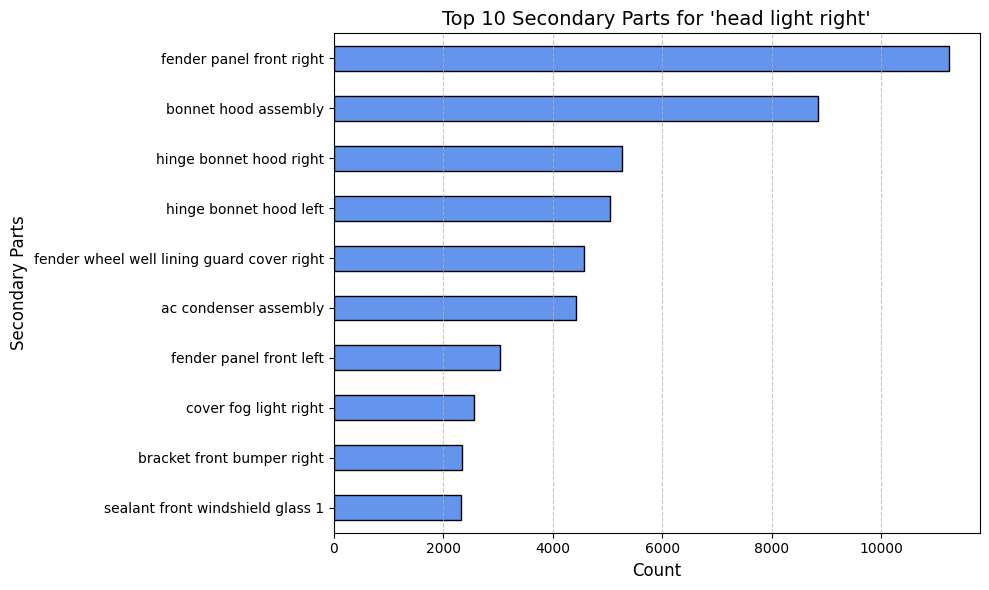

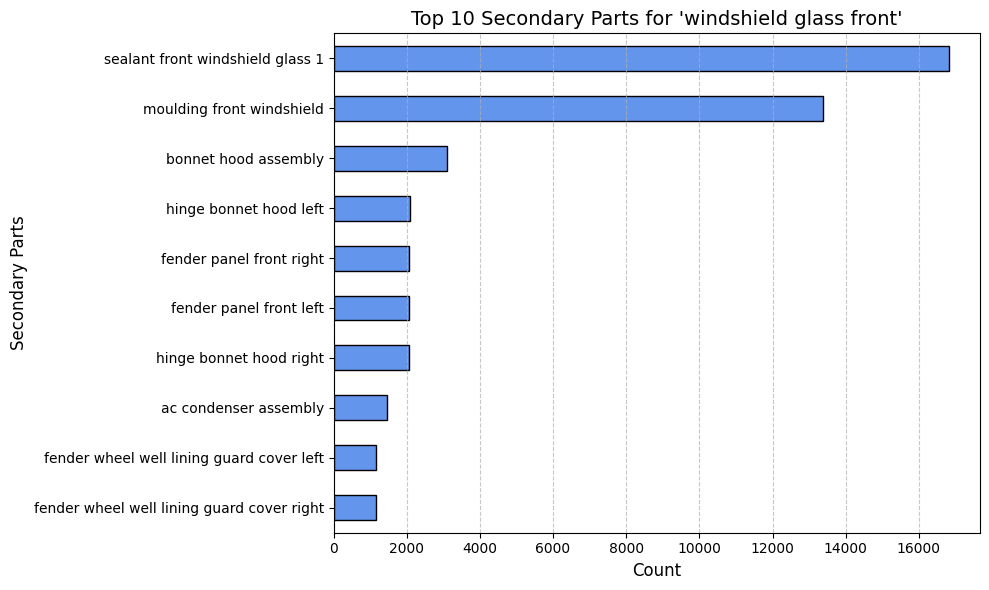

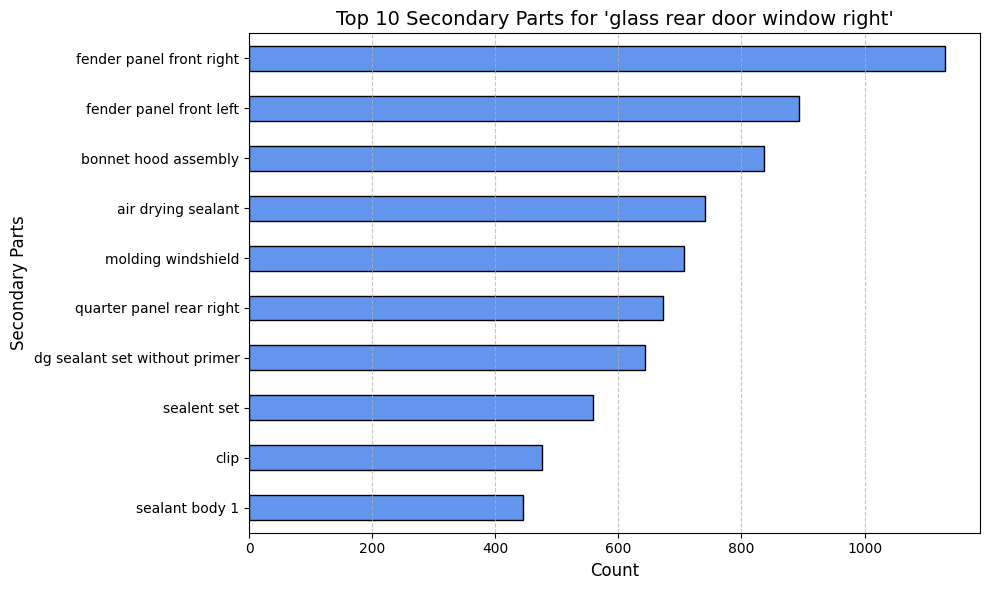

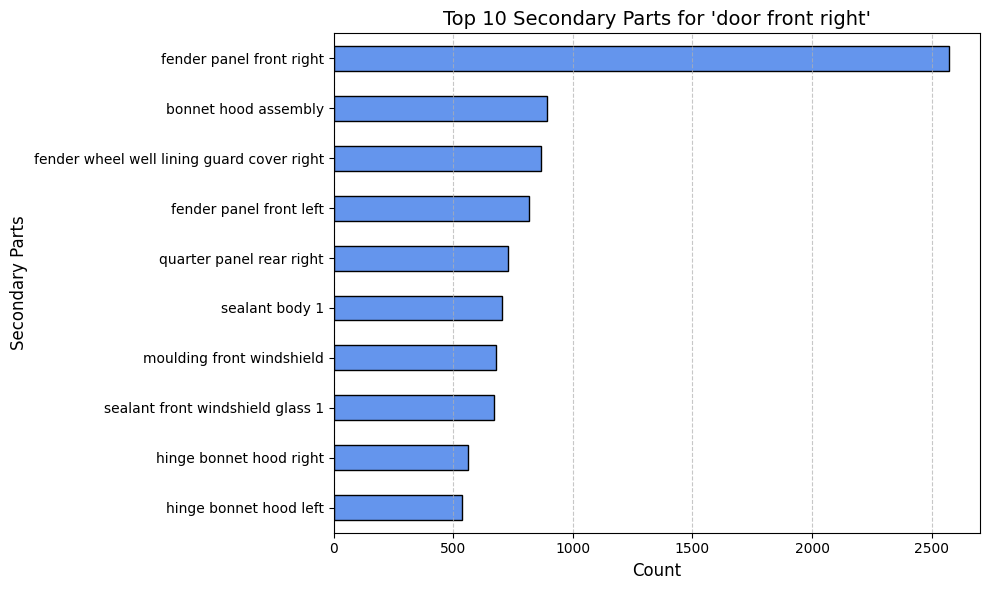

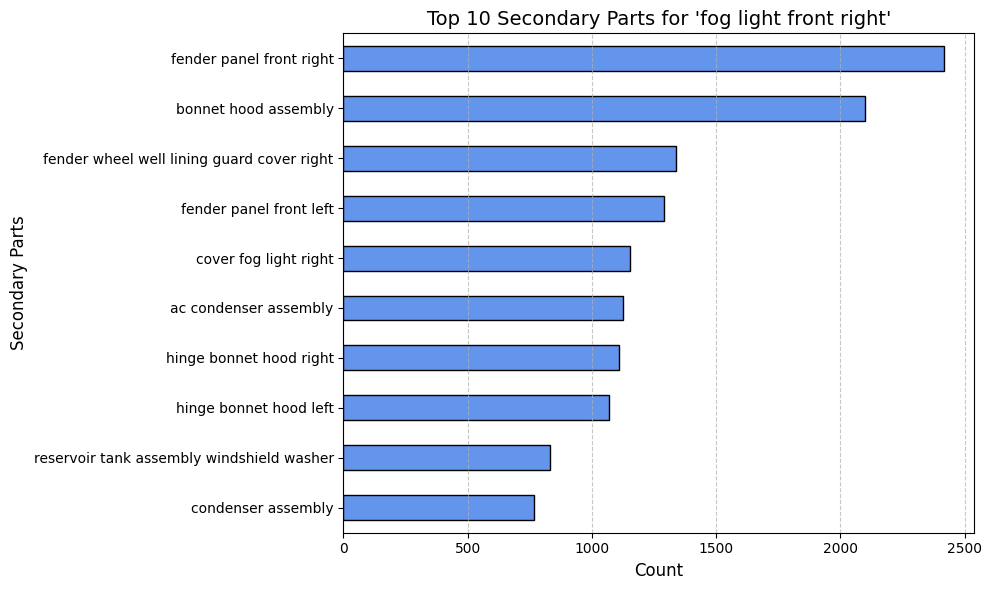

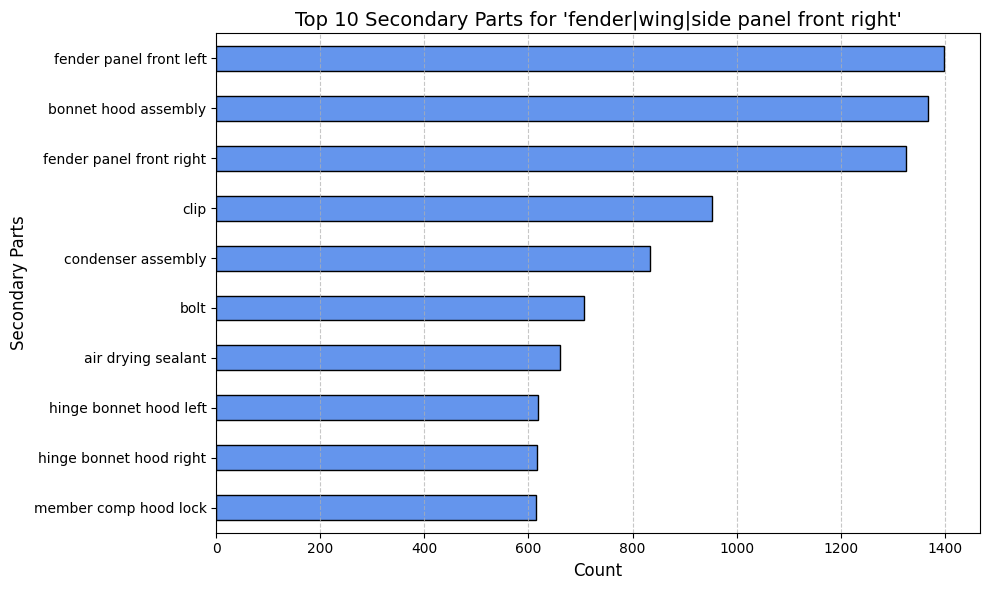

ModuleNotFoundError: No module named 'seaborn'

In [137]:
# Create claim-part matrix
claim_groups = df.groupby('CLAIMNO').agg({
    'primary_part': list,
    'secondary_part': list
}).reset_index()

# Analyze secondary associations
secondary_associations = {}

# Collect data for all top associations for heatmap creation
heatmap_data = []

for primary in primary_analysis['Primary Part'][:10]:  # Limit to top 10 for better readability
    # Get claims containing this primary part
    relevant_claims = claim_groups[
        claim_groups['primary_part'].apply(lambda x: primary in x if x else False)
    ]

    # Collect all secondary parts from these claims
    all_secondary = [
        part for sublist in relevant_claims['secondary_part']
        for part in sublist if part
    ]

    # Count occurrences
    counter = pd.Series(all_secondary).value_counts().head(10)  # Limit to top 10 secondary associations
    secondary_associations[primary] = counter

    # Prepare data for heatmap (fill NaN with 0 for missing keys)
    heatmap_data.append(counter.reindex(secondary_associations.keys(), fill_value=0))

    # Plotting bar chart for each primary part and its top secondary associations
    plt.figure(figsize=(10, 6))
    counter.sort_values(ascending=True).plot(kind='barh', color='cornflowerblue', edgecolor='black')
    plt.title(f"Top 10 Secondary Parts for '{primary}'", fontsize=14)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel("Secondary Parts", fontsize=12)
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Combine heatmap data into a DataFrame
heatmap_df = pd.DataFrame(heatmap_data).fillna(0)

# Plot heatmap for secondary associations using seaborn
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_df,
    annot=False,
    cmap="Blues",
    cbar_kws={'label': 'Count'},
    yticklabels=secondary_associations.keys()  # Primary parts as Y-axis labels
)
plt.title("Heatmap of Top Secondary Associations Across Primary Parts", fontsize=14)
plt.xlabel("Secondary Parts", fontsize=12)
plt.ylabel("Primary Parts", fontsize=12)
plt.tight_layout()
plt.show()

# Print the top associations (optional)
for primary, secondaries in secondary_associations.items():
    print(f"\nTop 10 Secondary Parts for '{primary}':")
    print(secondaries)

servyor data

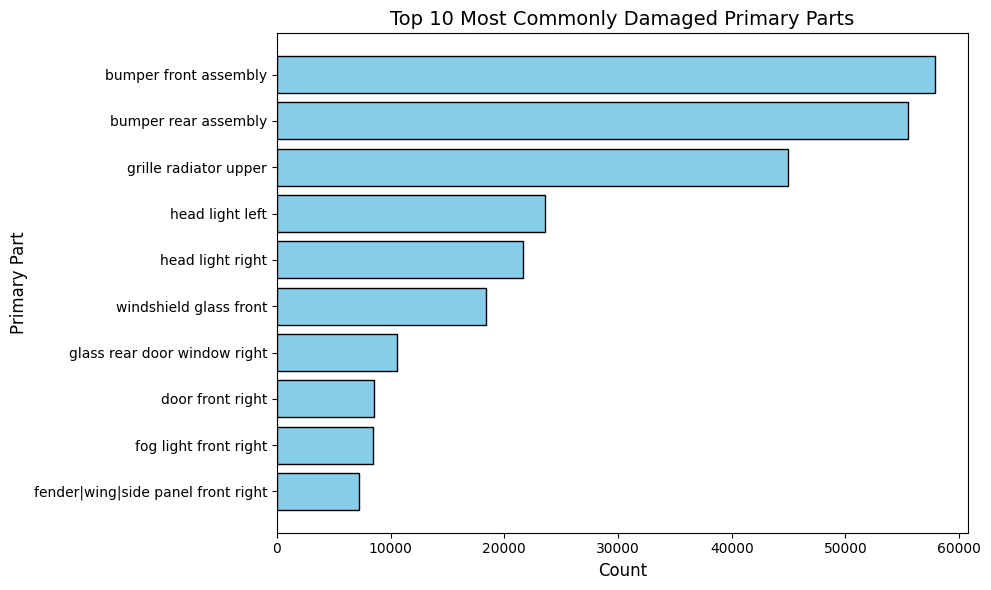

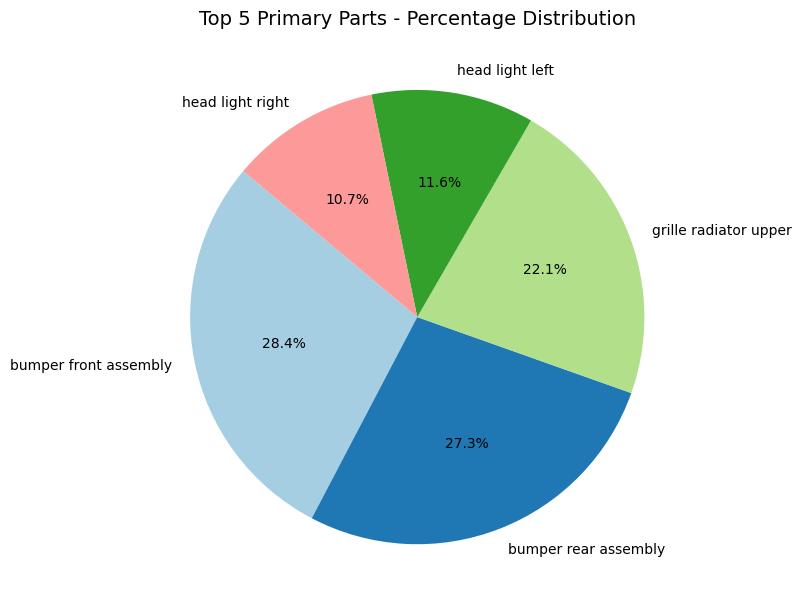

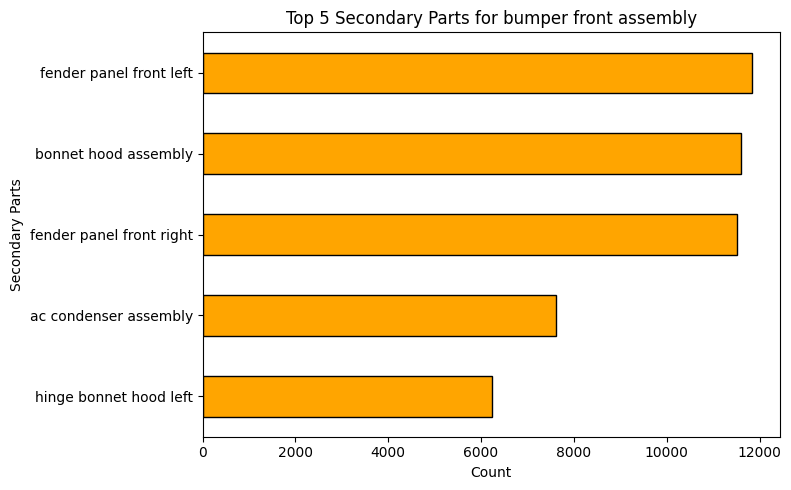

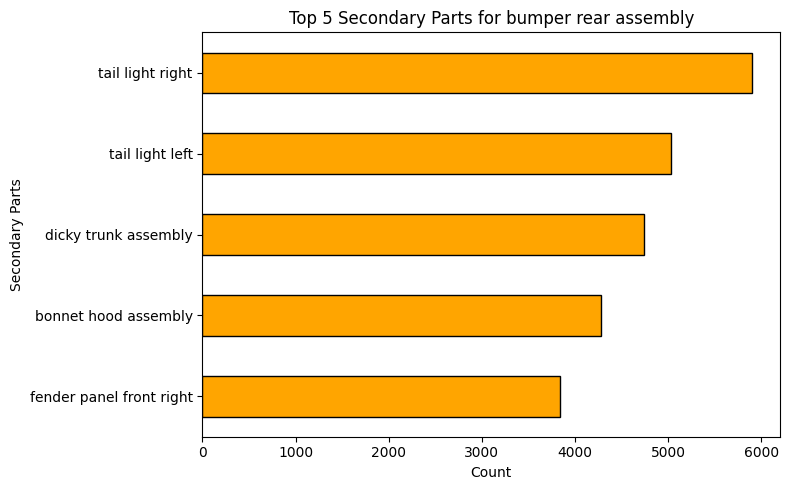

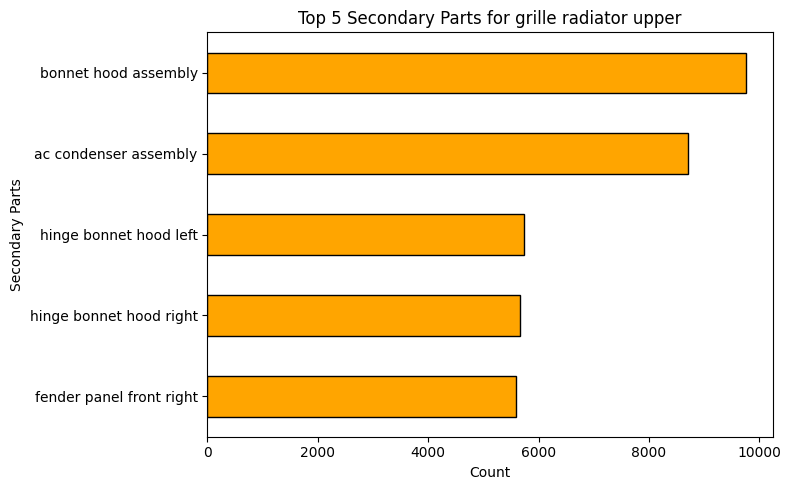

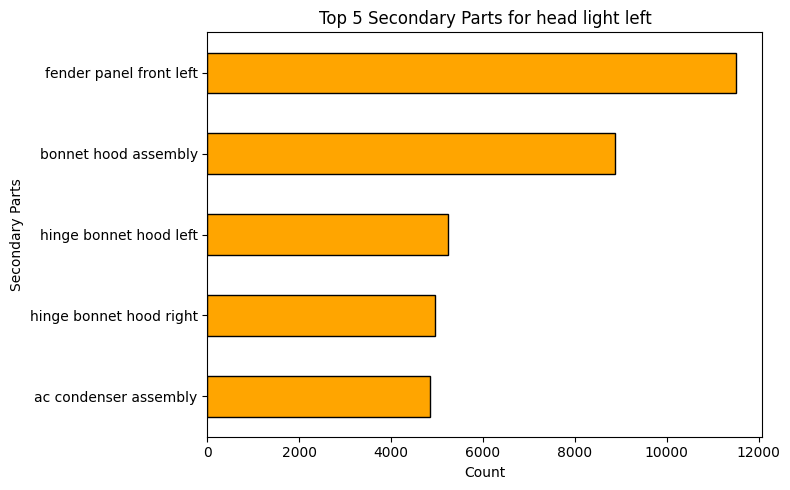

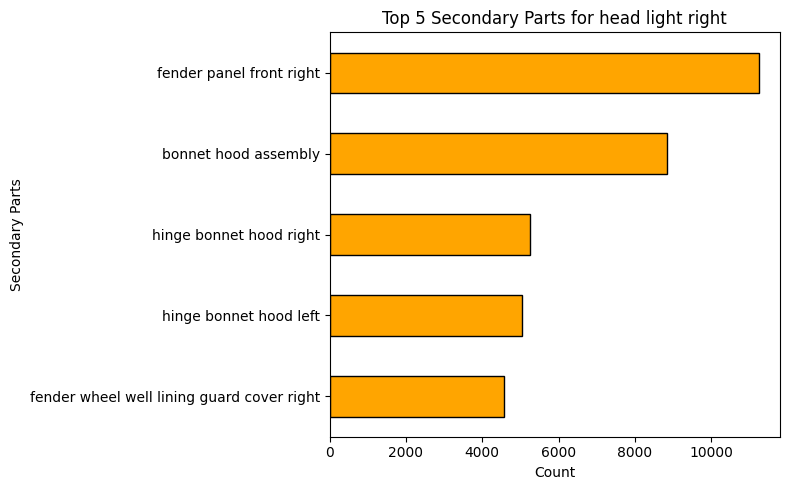

             primary_part             secondary_part
0                    None    emblem logo rear middle
1    bumper rear assembly                       None
2  windshield glass front                       None
3                    None  moulding front windshield
4                    None       bonnet hood assembly


In [131]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("../surveyor_data_cleanedd.csv")

# Load part mapping JSON file
with open("Bigdeduplicated_mapping.json") as f:
    part_mapping = json.load(f)

# Create reverse mapping and primary part set
reverse_map = {}
primary_part_set = set()

for primary_part, secondary_list in part_mapping.items():
    # Normalize primary parts
    normalized_primary = primary_part.lower().strip()
    primary_part_set.add(normalized_primary)

    for secondary in secondary_list:
        # Normalize secondary parts
        normalized_secondary = secondary.lower().strip()
        reverse_map[normalized_secondary] = normalized_primary


# Function to categorize parts based on mappings
def categorize_part(part_description):
    # Handle missing/null part descriptions
    if pd.isnull(part_description):
        return None

    # Normalize the part description
    normalized_part = part_description.lower().strip()

    # Check primary or secondary part mappings
    if normalized_part in reverse_map:
        return reverse_map[normalized_part]  # Map to the primary part
    elif normalized_part in primary_part_set:
        return normalized_part  # It's already a primary part
    else:
        return None  # No match found


# Apply categorization to the `TXT_PARTS_NAME` column
df['primary_part'] = df['TXT_PARTS_NAME'].apply(categorize_part)

# Create a secondary part column for unmapped records
df['secondary_part'] = df.apply(
    lambda x: x['TXT_PARTS_NAME'] if pd.isnull(x['primary_part']) else None,
    axis=1
)

# Ensure `VEHICLE_MODEL_CODE` is converted to integers if appropriate
# and handle potential nulls in `VEHICLE_MODEL_CODE`
if df['VEHICLE_MODEL_CODE'].notnull().all():
    df['VEHICLE_MODEL_CODE'] = df['VEHICLE_MODEL_CODE'].astype(int, errors='ignore')
else:
    df['VEHICLE_MODEL_CODE'] = df['VEHICLE_MODEL_CODE'].fillna(0).astype(int)

# Analyze primary parts
primary_analysis = df['primary_part'].value_counts().reset_index()
primary_analysis.columns = ['Primary Part', 'Count']
total = primary_analysis['Count'].sum()
primary_analysis['Percentage'] = (primary_analysis['Count'] / total * 100).round(2)

# Visualization: Horizontal bar chart for top 10 most commonly damaged parts
plt.figure(figsize=(10, 6))
plt.barh(primary_analysis['Primary Part'][:10], primary_analysis['Count'][:10], color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()  # Largest value on top
plt.title("Top 10 Most Commonly Damaged Primary Parts", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Primary Part", fontsize=12)
plt.tight_layout()
plt.show()

# Visualization: Pie chart for percentage distribution of top 5 primary parts
plt.figure(figsize=(8, 8))
plt.pie(
    primary_analysis['Percentage'][:5],
    labels=primary_analysis['Primary Part'][:5],
    autopct='%1.1f%%',
    colors=plt.cm.Paired.colors,  # Use a color palette for better visuals
    startangle=140
)
plt.title("Top 5 Primary Parts - Percentage Distribution", fontsize=14)
plt.tight_layout()
plt.show()

# Create a secondary part analysis visualization
# Analyze secondary associations
claim_groups = df.groupby('CLAIMNO').agg({
    'primary_part': list,
    'secondary_part': list
}).reset_index()

secondary_associations = {}

for primary in primary_analysis['Primary Part'][:5]:  # Limit to top 5 for visualization
    # Get claims containing this primary part
    relevant_claims = claim_groups[
        claim_groups['primary_part'].apply(lambda x: primary in x if x else False)
    ]

    # Collect all secondary parts from these claims
    all_secondary = [
        part for sublist in relevant_claims['secondary_part']
        for part in sublist if part
    ]

    # Count occurrences
    counter = pd.Series(all_secondary).value_counts().head(5)  # Top 5 secondary associations
    secondary_associations[primary] = counter

    # Plot top secondary associations for the primary part
    plt.figure(figsize=(8, 5))
    counter.sort_values(ascending=True).plot(kind='barh', color='orange', edgecolor='black')
    plt.title(f"Top 5 Secondary Parts for {primary}", fontsize=12)
    plt.xlabel("Count", fontsize=10)
    plt.ylabel("Secondary Parts", fontsize=10)
    plt.tight_layout()
    plt.show()

# Output processed DataFrame (optional)
print(df[['primary_part', 'secondary_part']].head())

# Save the updated DataFrame to a new file (optional)
df.to_csv("processed_surveyor_data.csv", index=False)

Most Commonly Damaged Primary Parts:
                         Primary Part  Count  Percentage
0               bumper front assembly  57853       20.07
1                bumper rear assembly  55477       19.24
2               grille radiator upper  44949       15.59
3                     head light left  23575        8.18
4                    head light right  21675        7.52
5              windshield glass front  18359        6.37
6        glass rear door window right  10605        3.68
7                    door front right   8555        2.97
8               fog light front right   8408        2.92
9  fender|wing|side panel front right   7227        2.51


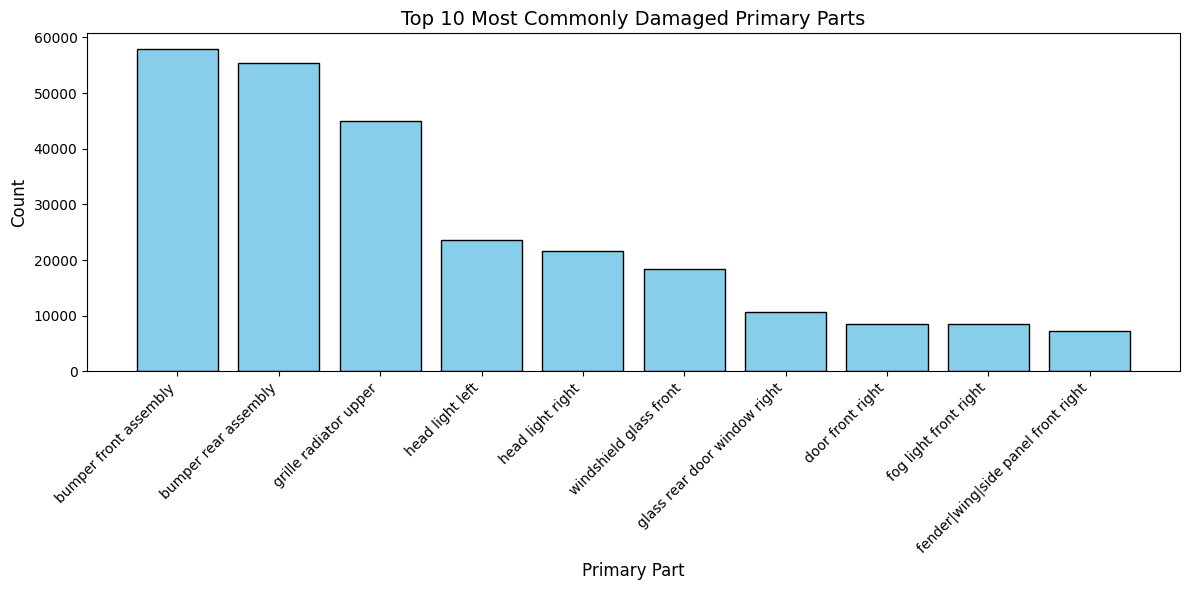

In [130]:
import matplotlib.pyplot as plt

primary_analysis = df['primary_part'].value_counts().reset_index()
primary_analysis.columns = ['Primary Part', 'Count']
total = primary_analysis['Count'].sum()
primary_analysis['Percentage'] = (primary_analysis['Count'] / total * 100).round(2)

# Print most commonly damaged primary parts
print("Most Commonly Damaged Primary Parts:")
print(primary_analysis.head(10))

# Visualization: Bar chart for top 10 most commonly damaged parts
plt.figure(figsize=(12, 6))
plt.bar(primary_analysis['Primary Part'][:10], primary_analysis['Count'][:10], color='skyblue', edgecolor='black')
plt.title("Top 10 Most Commonly Damaged Primary Parts", fontsize=14)
plt.xlabel("Primary Part", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

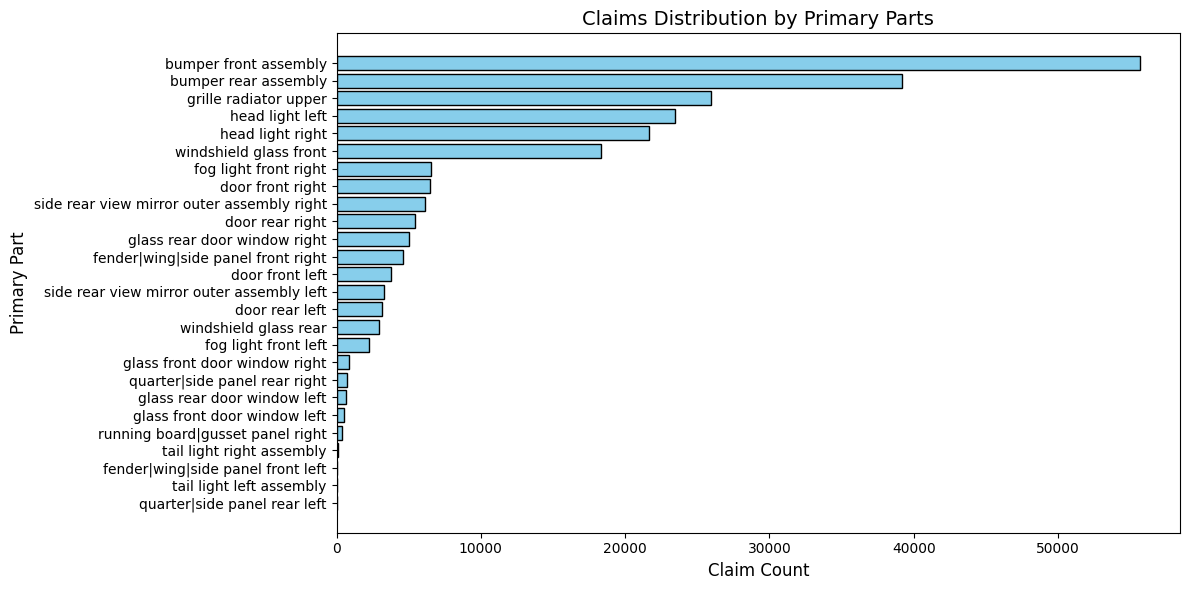

In [129]:
import matplotlib.pyplot as plt

claims_distribution = df.groupby('primary_part')['CLAIMNO'].nunique().reset_index()
claims_distribution.columns = ['Primary Part', 'Claim Count']

# Sort the data by 'Claim Count' in descending order for better visualization
claims_distribution = claims_distribution.sort_values('Claim Count', ascending=False)

# Display the data as a bar chart
plt.figure(figsize=(12, 6))
plt.barh(claims_distribution['Primary Part'], claims_distribution['Claim Count'], color='skyblue', edgecolor='black')
plt.title("Claims Distribution by Primary Parts", fontsize=14)
plt.xlabel("Claim Count", fontsize=12)
plt.ylabel("Primary Part", fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to show the largest values first
plt.tight_layout()
plt.show()

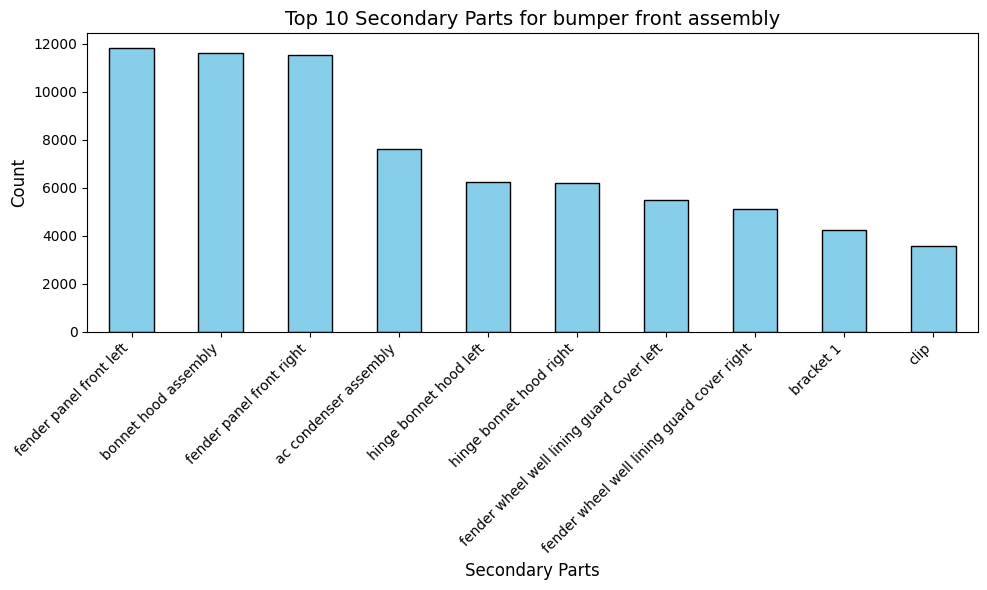

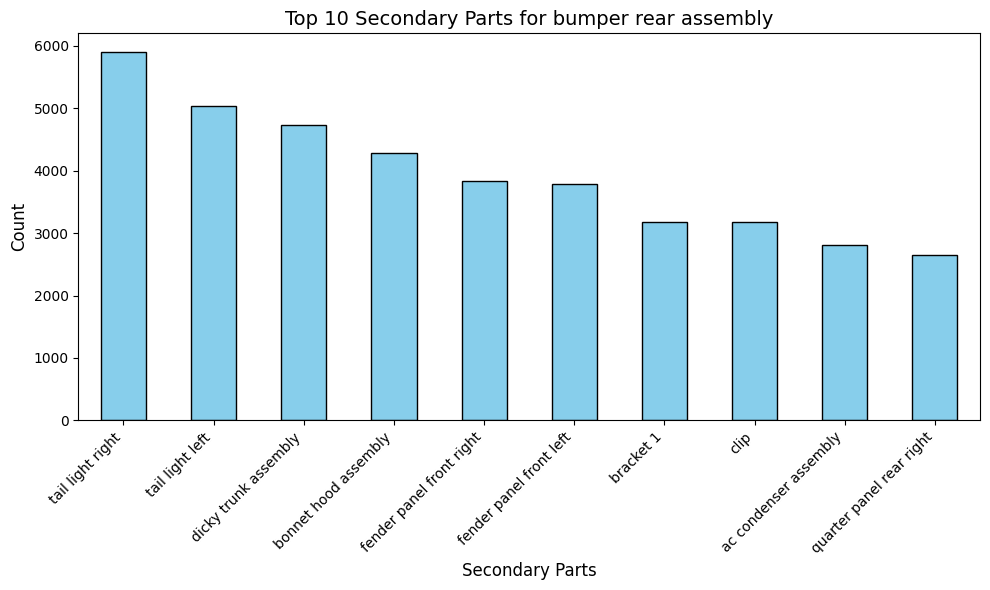

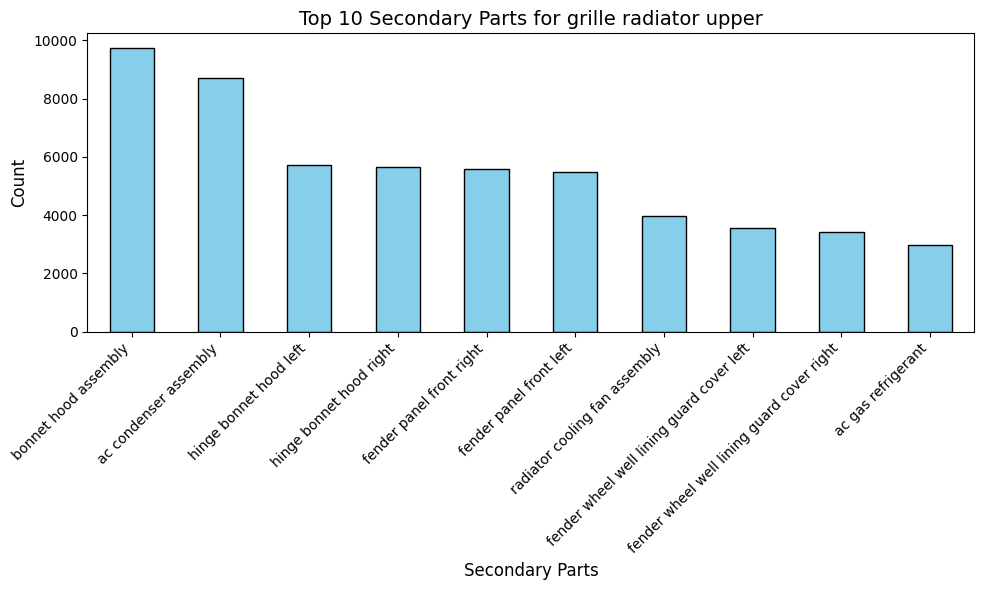

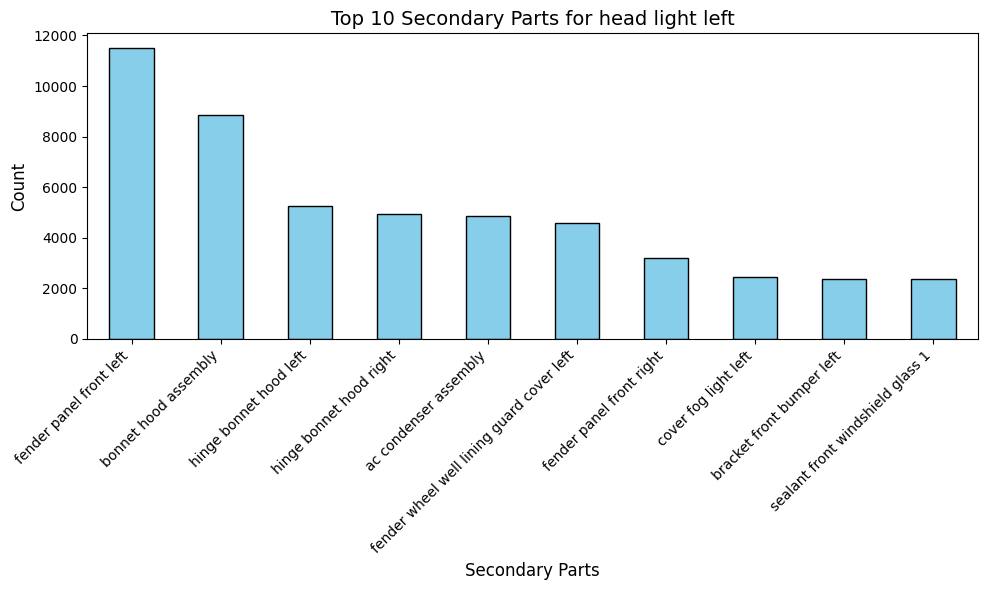

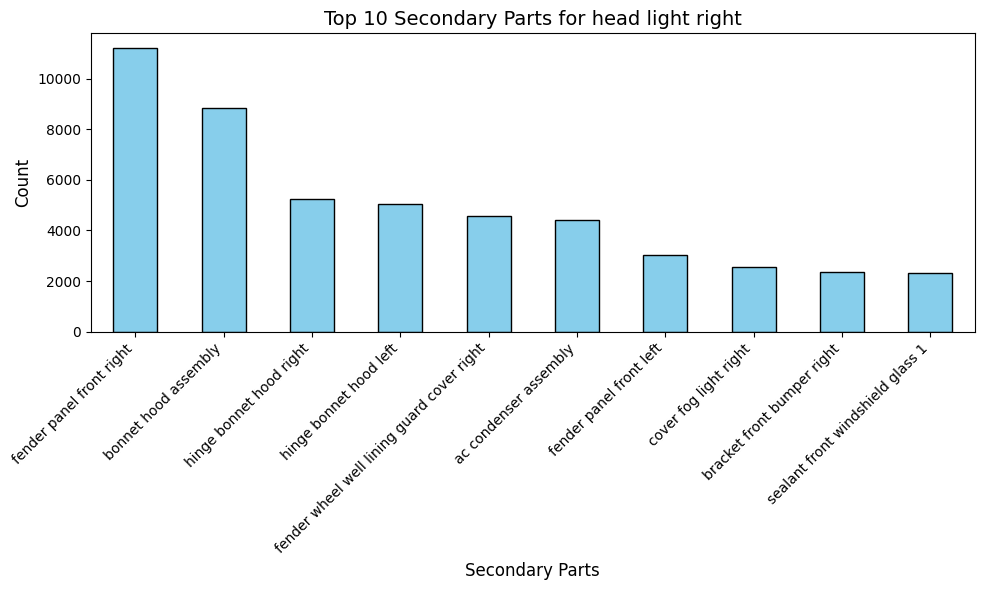

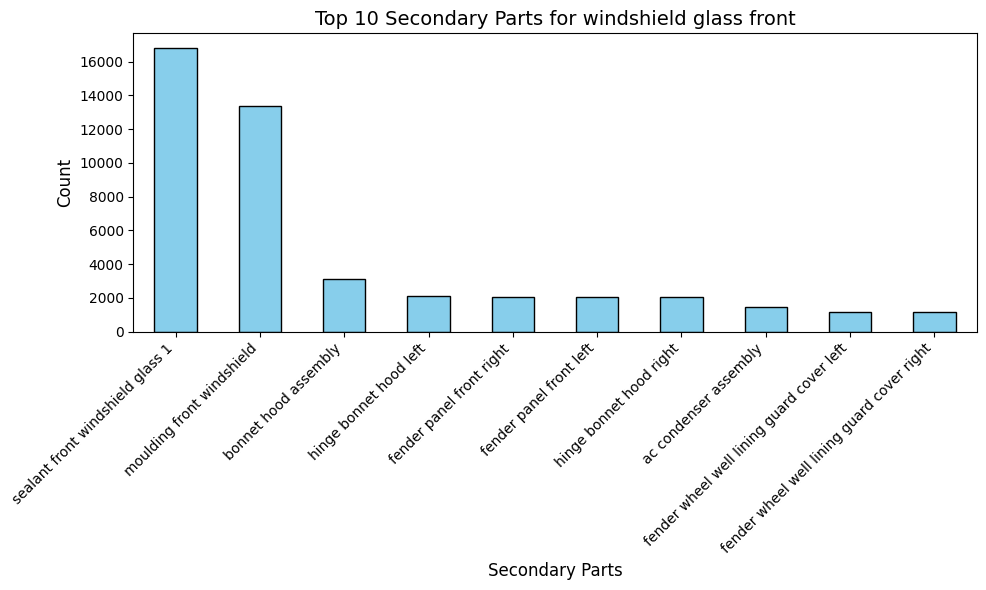

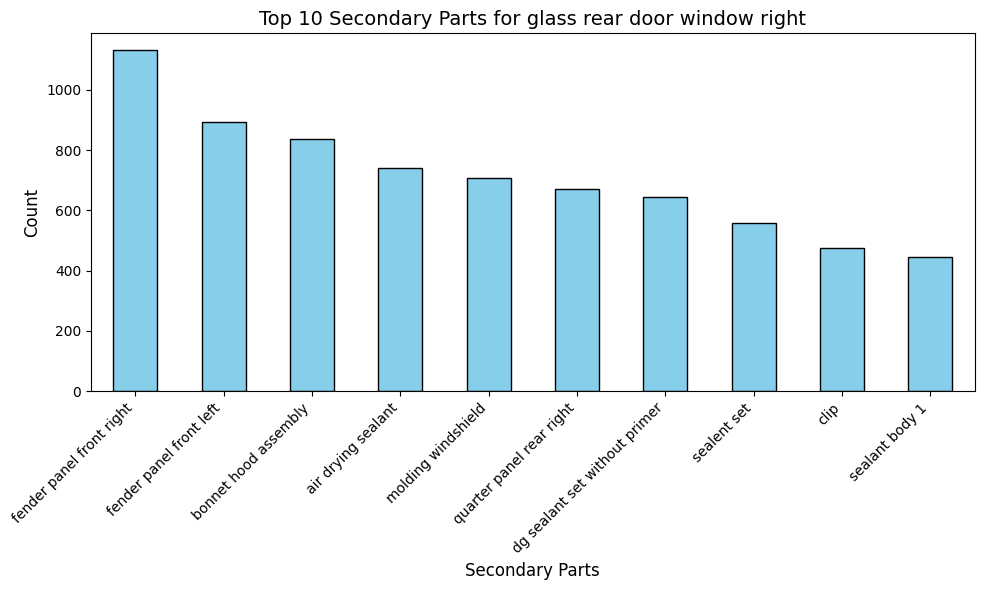

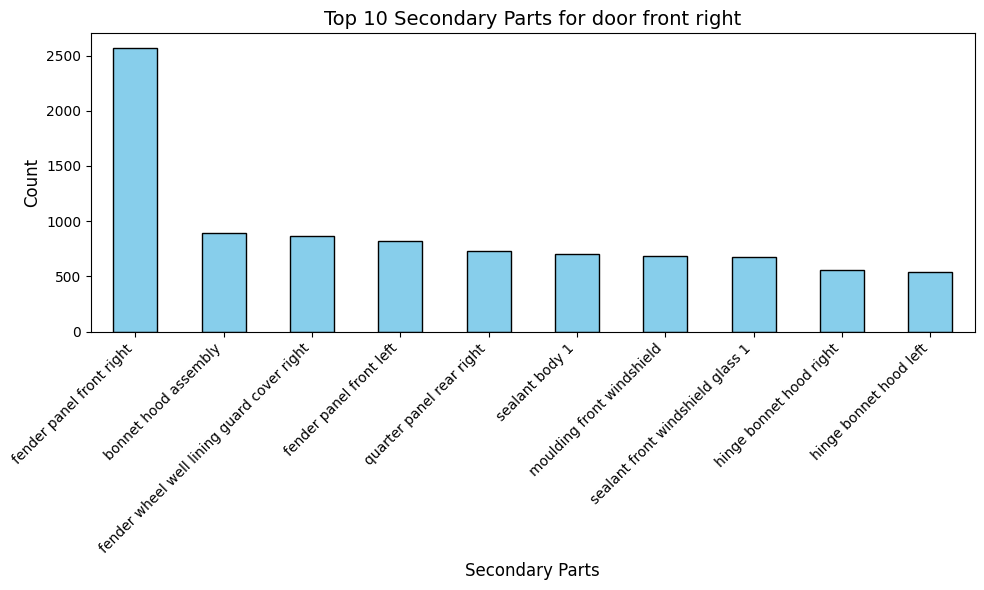

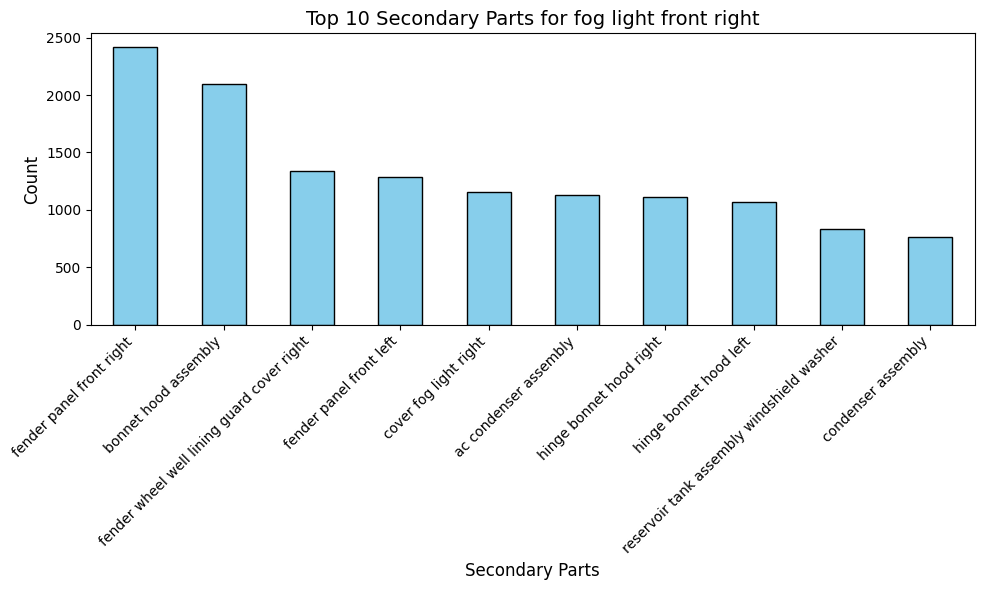

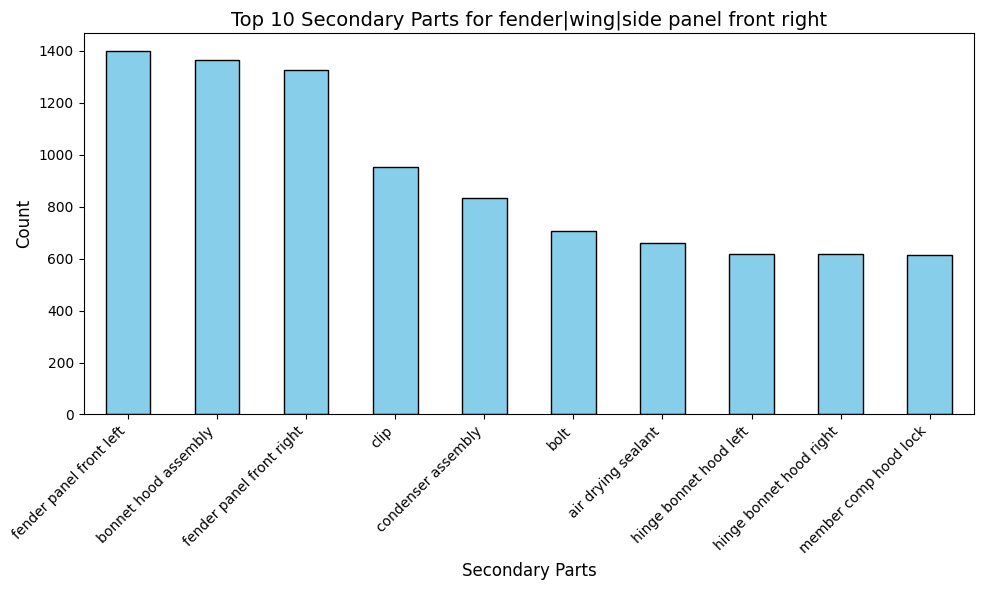

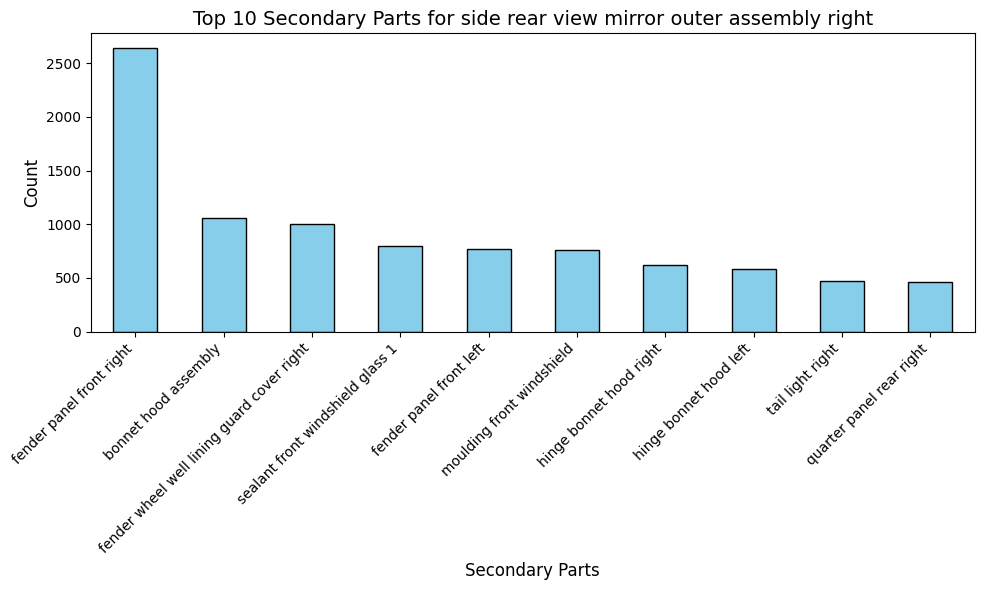

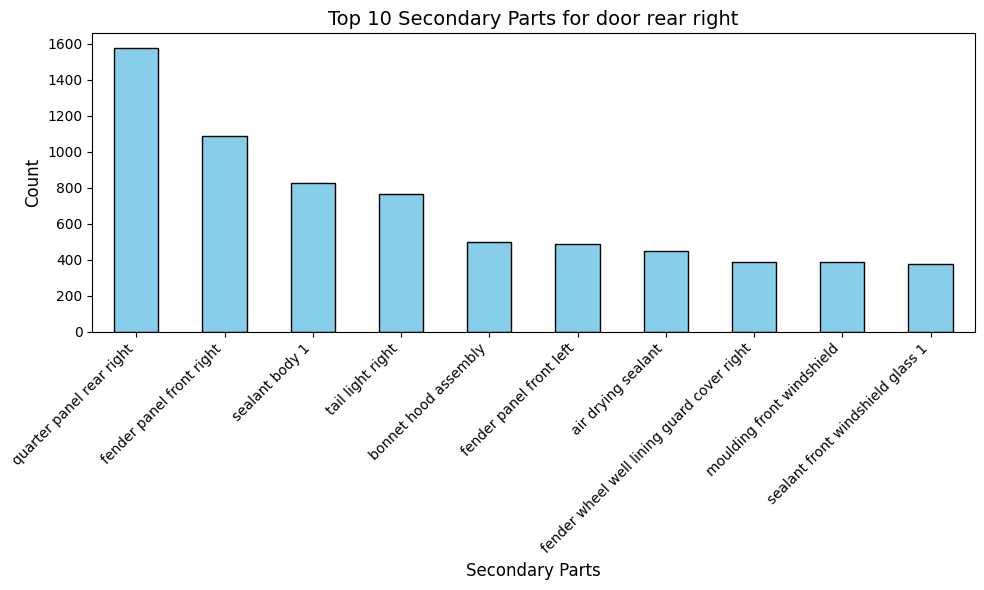

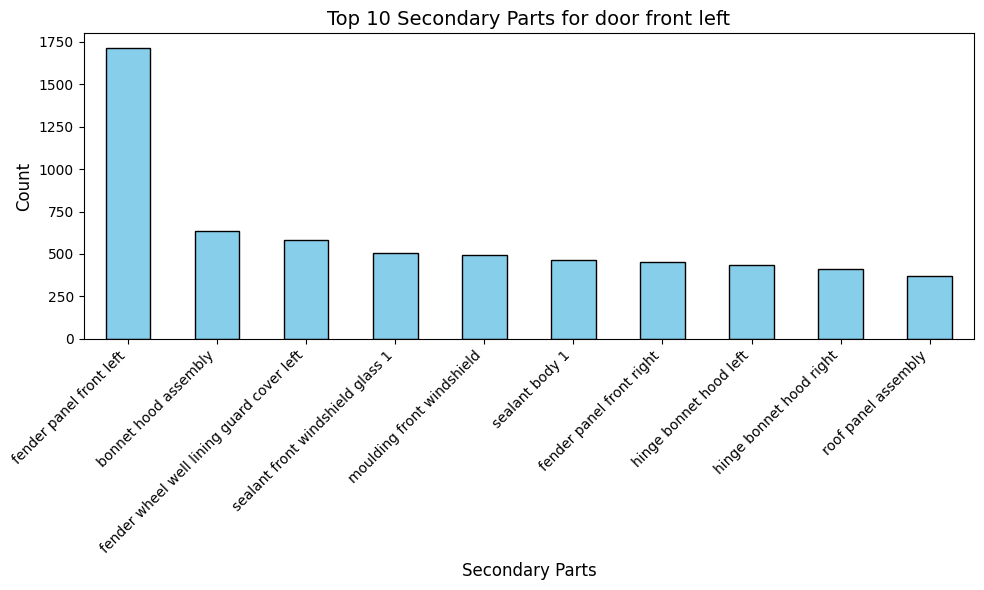

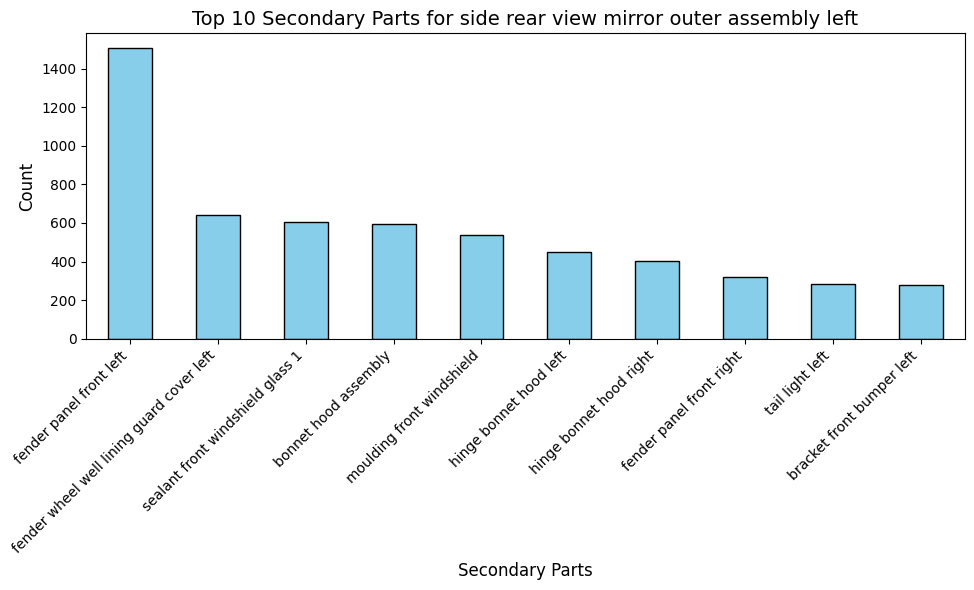

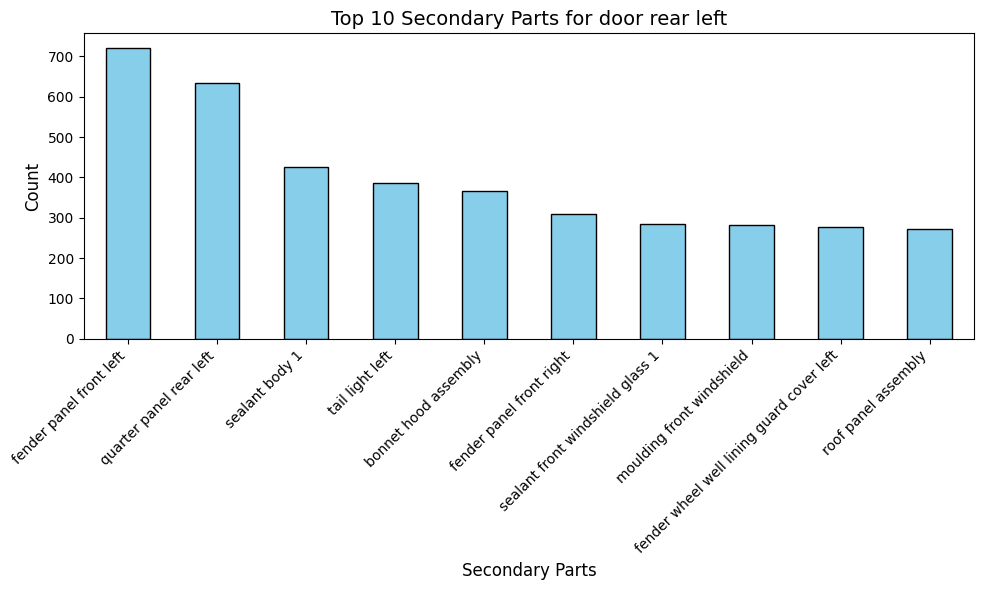

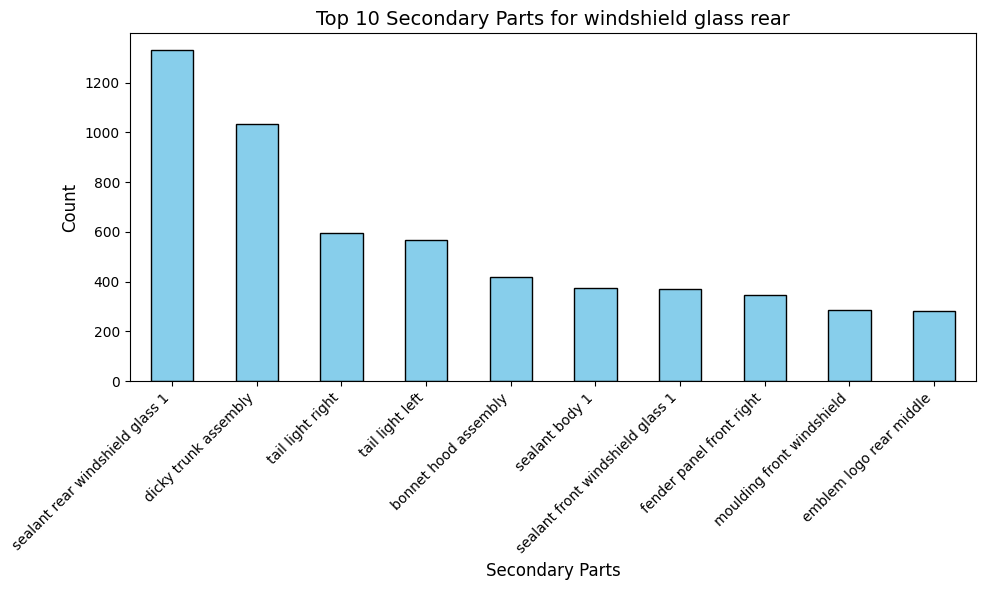

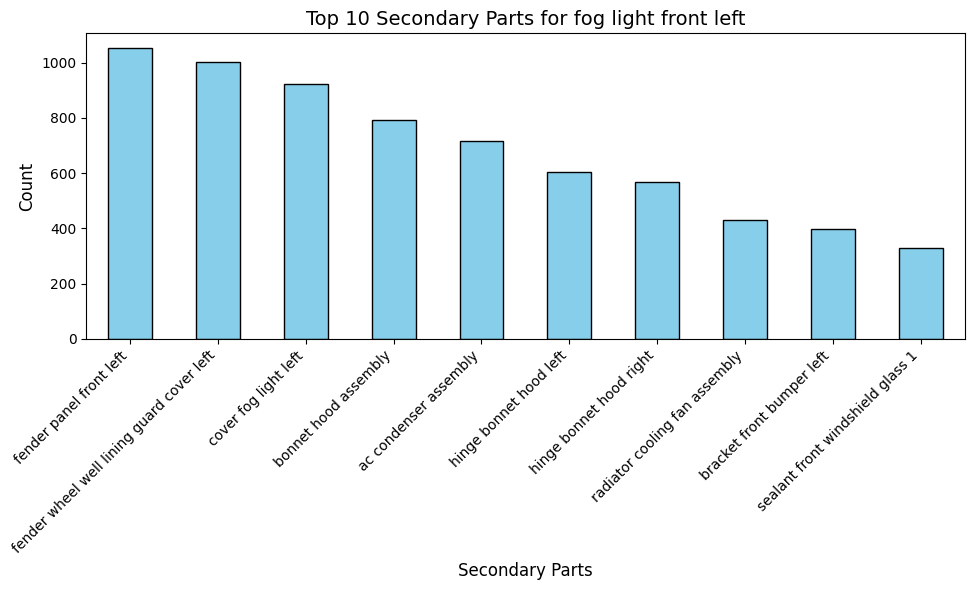

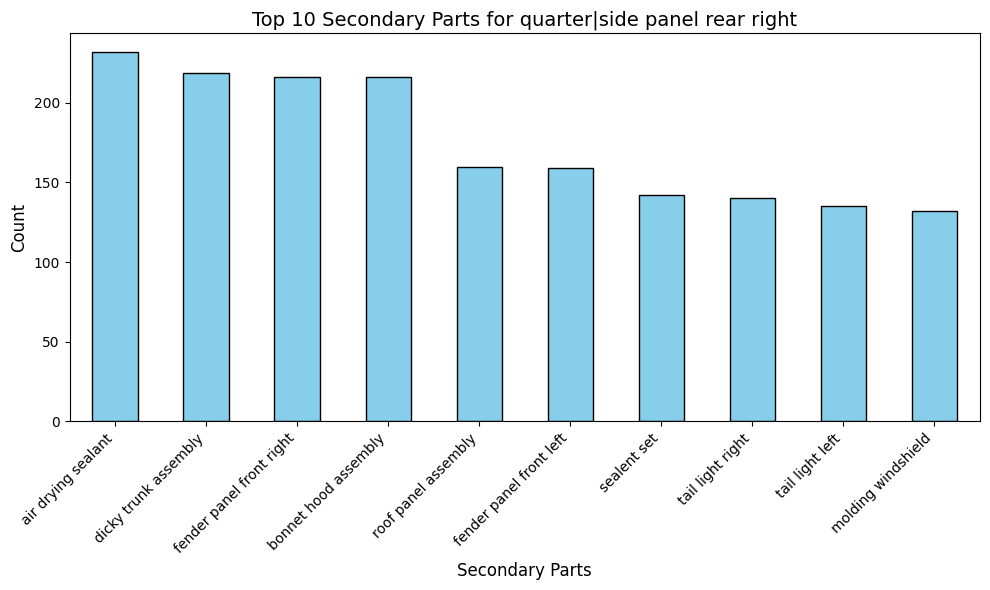

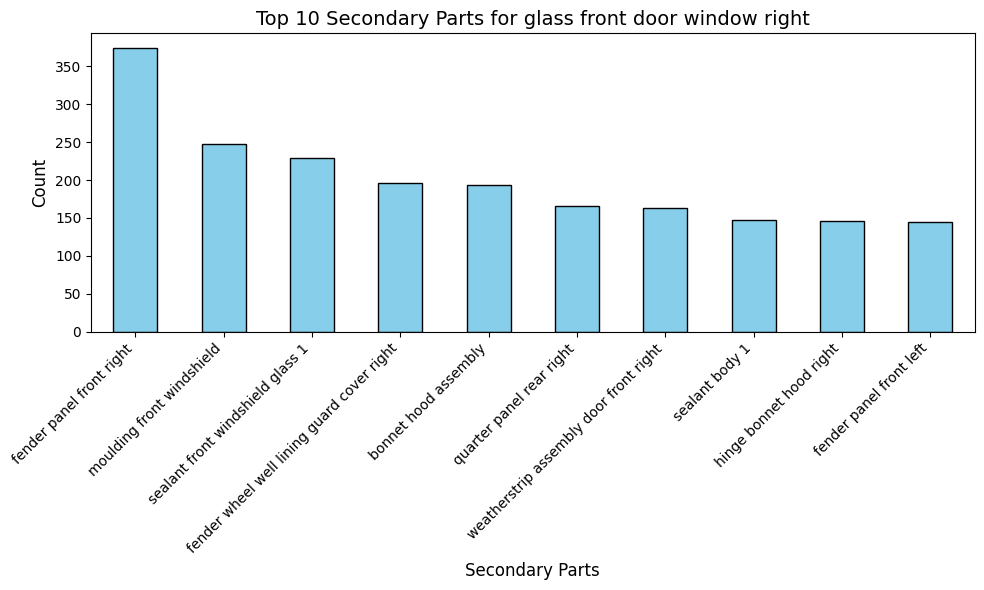

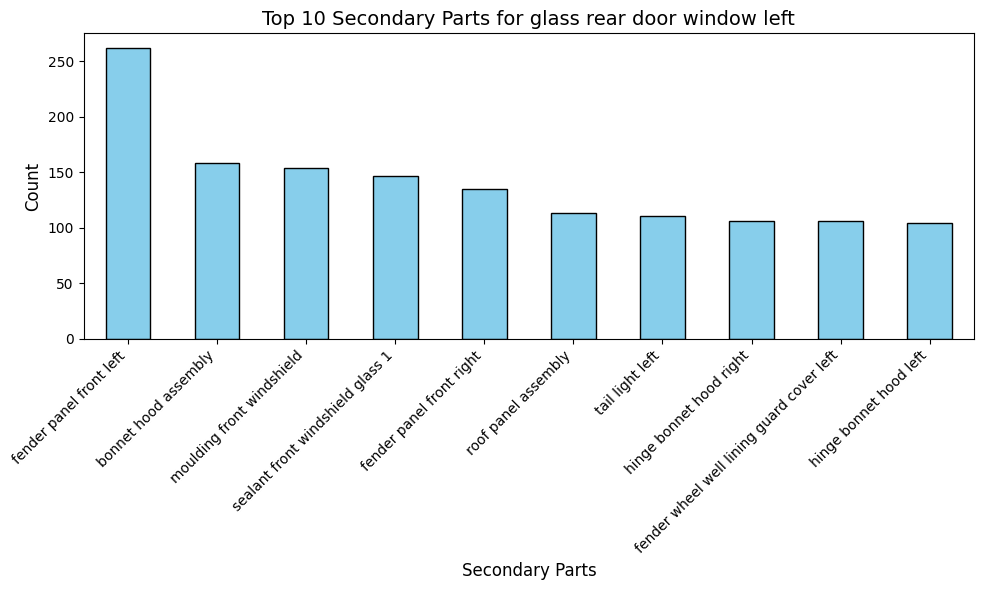

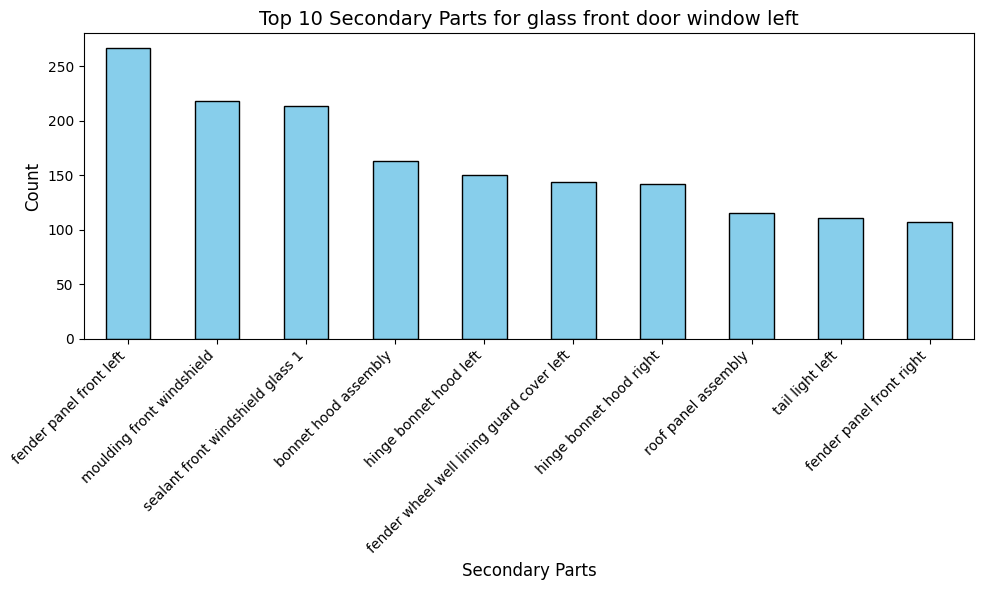

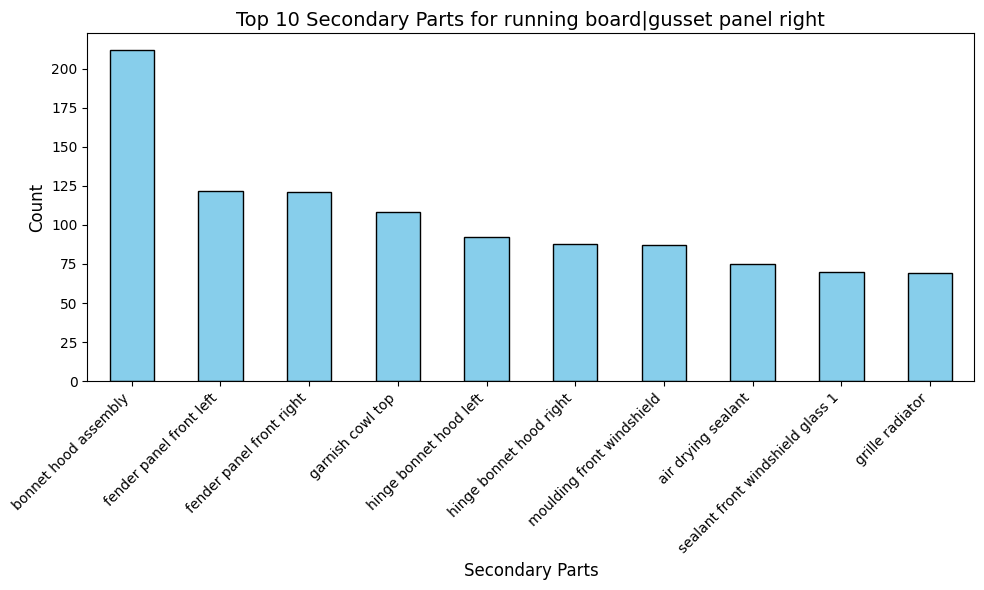

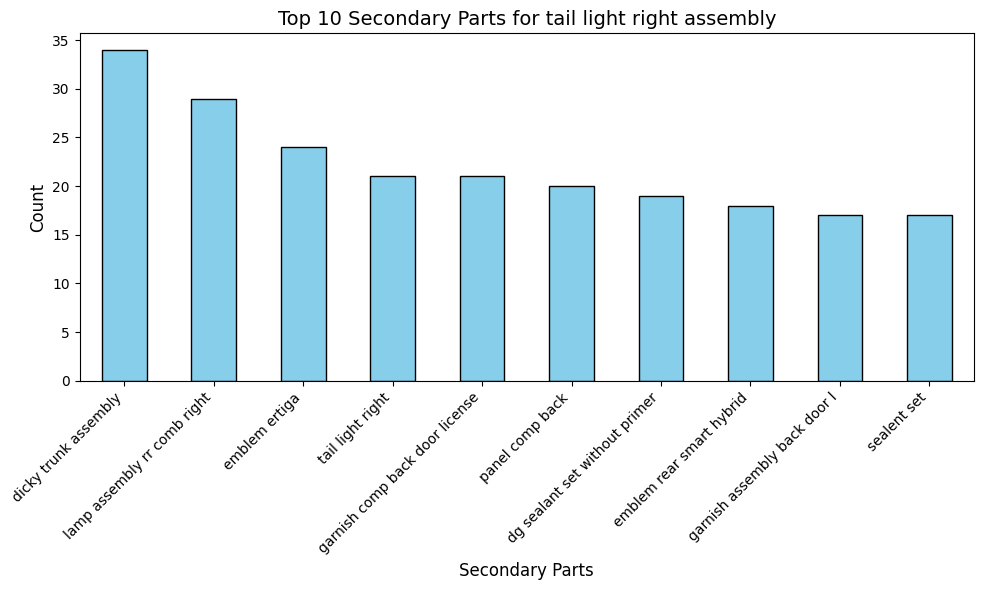

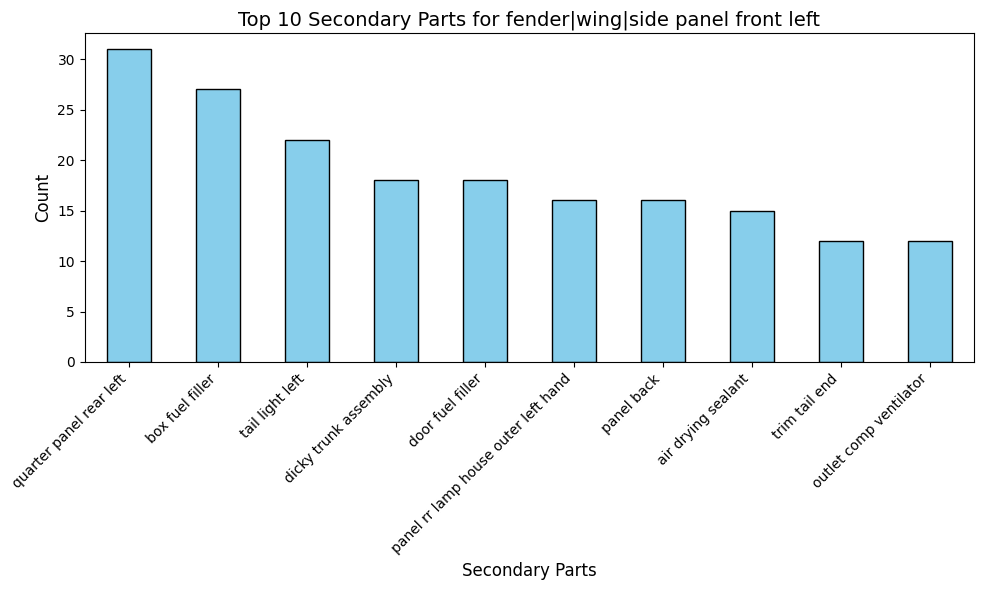

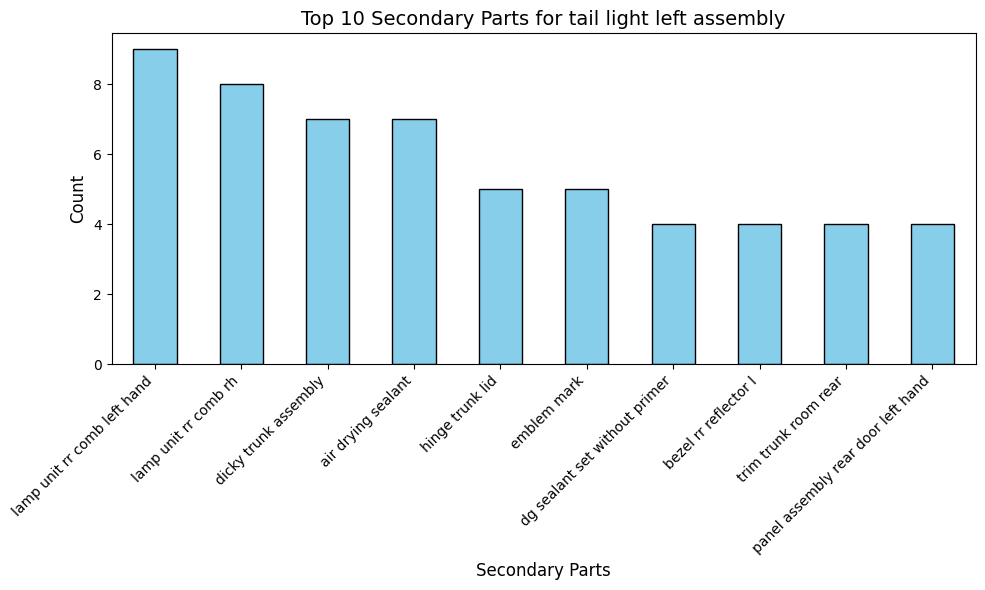

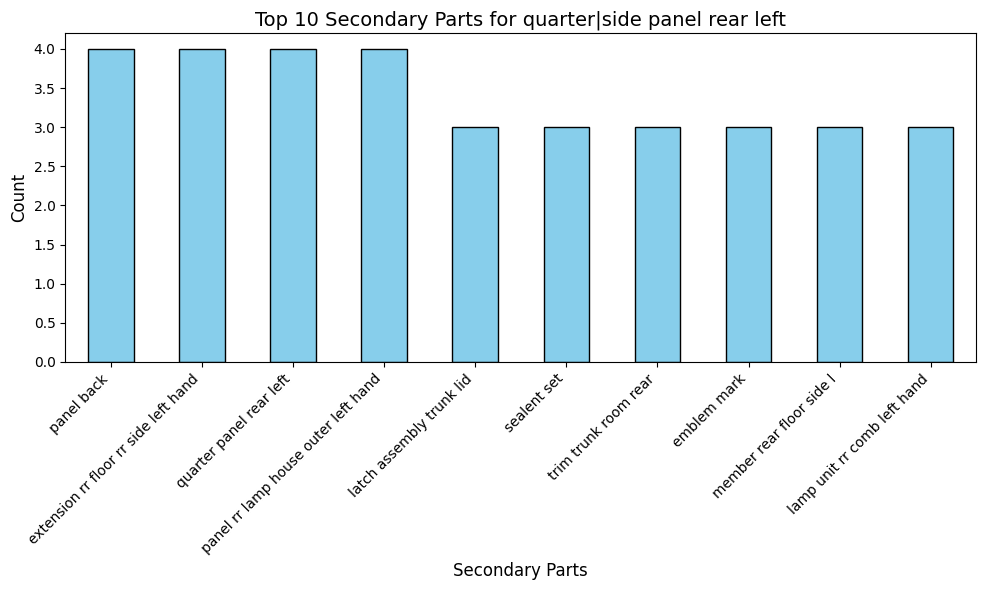


Top 10 Secondary Parts for bumper front assembly:
fender panel front left                       11840
bonnet hood assembly                          11611
fender panel front right                      11524
ac condenser assembly                          7620
hinge bonnet hood left                         6228
hinge bonnet hood right                        6176
fender wheel well lining guard cover left      5503
fender wheel well lining guard cover right     5124
bracket 1                                      4231
clip                                           3571
Name: count, dtype: int64

Top 10 Secondary Parts for bumper rear assembly:
tail light right            5906
tail light left             5032
dicky trunk assembly        4740
bonnet hood assembly        4279
fender panel front right    3838
fender panel front left     3795
bracket 1                   3183
clip                        3175
ac condenser assembly       2808
quarter panel rear right    2645
Name: count, dtype: int

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Create claim-part matrix
claim_groups = df.groupby('CLAIMNO').agg({
    'primary_part': list,
    'secondary_part': list
}).reset_index()

# Analyze secondary associations
secondary_associations = {}

for primary in primary_analysis['Primary Part']:
    # Get claims containing this primary part
    relevant_claims = claim_groups[
        claim_groups['primary_part'].apply(lambda x: primary in x if x else False)
    ]

    # Collect all secondary parts from these claims
    all_secondary = [
        part for sublist in relevant_claims['secondary_part']
        for part in sublist if part
    ]

    # Count occurrences
    counter = pd.Series(all_secondary).value_counts().head(10)
    secondary_associations[primary] = counter

    # Plot top secondary associations for the primary part
    plt.figure(figsize=(10, 6))
    counter.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top 10 Secondary Parts for {primary}", fontsize=14)
    plt.ylabel("Count", fontsize=12)
    plt.xlabel("Secondary Parts", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()

# Print results
for primary, secondaries in secondary_associations.items():
    print(f"\nTop 10 Secondary Parts for {primary}:")
    print(secondaries)